In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [10]:
(1236 - 1) % 20

15

In [2]:
path = "/Users/hamzaabdelhedi/Projects/data/MFRS_data/"
rdms_folder = os.path.join(path, "networks_rdms")
plots_folder = os.path.join(path, "plots")
subjects_dir = os.path.join(path, "subjects")
similarity_folder = os.path.join(path, "similarity_scores")

In [6]:
all_data = []
for i in range(7):
    data_file = os.path.join(rdms_folder, f"{i+1:02d}_FaceNet_None_rdm_untrained.npy")
    data = np.load(data_file)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)
print(all_data.shape)
np.save(os.path.join(rdms_folder, "FaceNet_None_rdm_untrained.npy"), all_data)

(404, 428, 428)


In [486]:
results = {}
for model in ["vgg16_bn", "cornet_s", "SphereFace", "FaceNet", "resnet50", "mobilenet", "inception_v3"]:
    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained.npy")
    data = np.load(data_file)
    max_val = np.max(data[:, 2, :, 0])
    max_index = np.unravel_index(np.argmax(data[:, :, :, 0]), data[:, :, :, 0].shape)
    results[model] = (max_val, max_index)
    print(f"{model}: {max_val} at {max_index}")


vgg16_bn: 0.09006365169468357 at (64, 0, 31)
cornet_s: 0.10414789981787455 at (111, 1, 24)
SphereFace: 0.10557519514563005 at (10, 0, 4)
FaceNet: 0.12155989861156848 at (119, 2, 294)
resnet50: 0.10341554788166103 at (119, 2, 104)
mobilenet: 0.10070543728433144 at (119, 2, 115)
inception_v3: 0.11016920859833551 at (119, 2, 80)


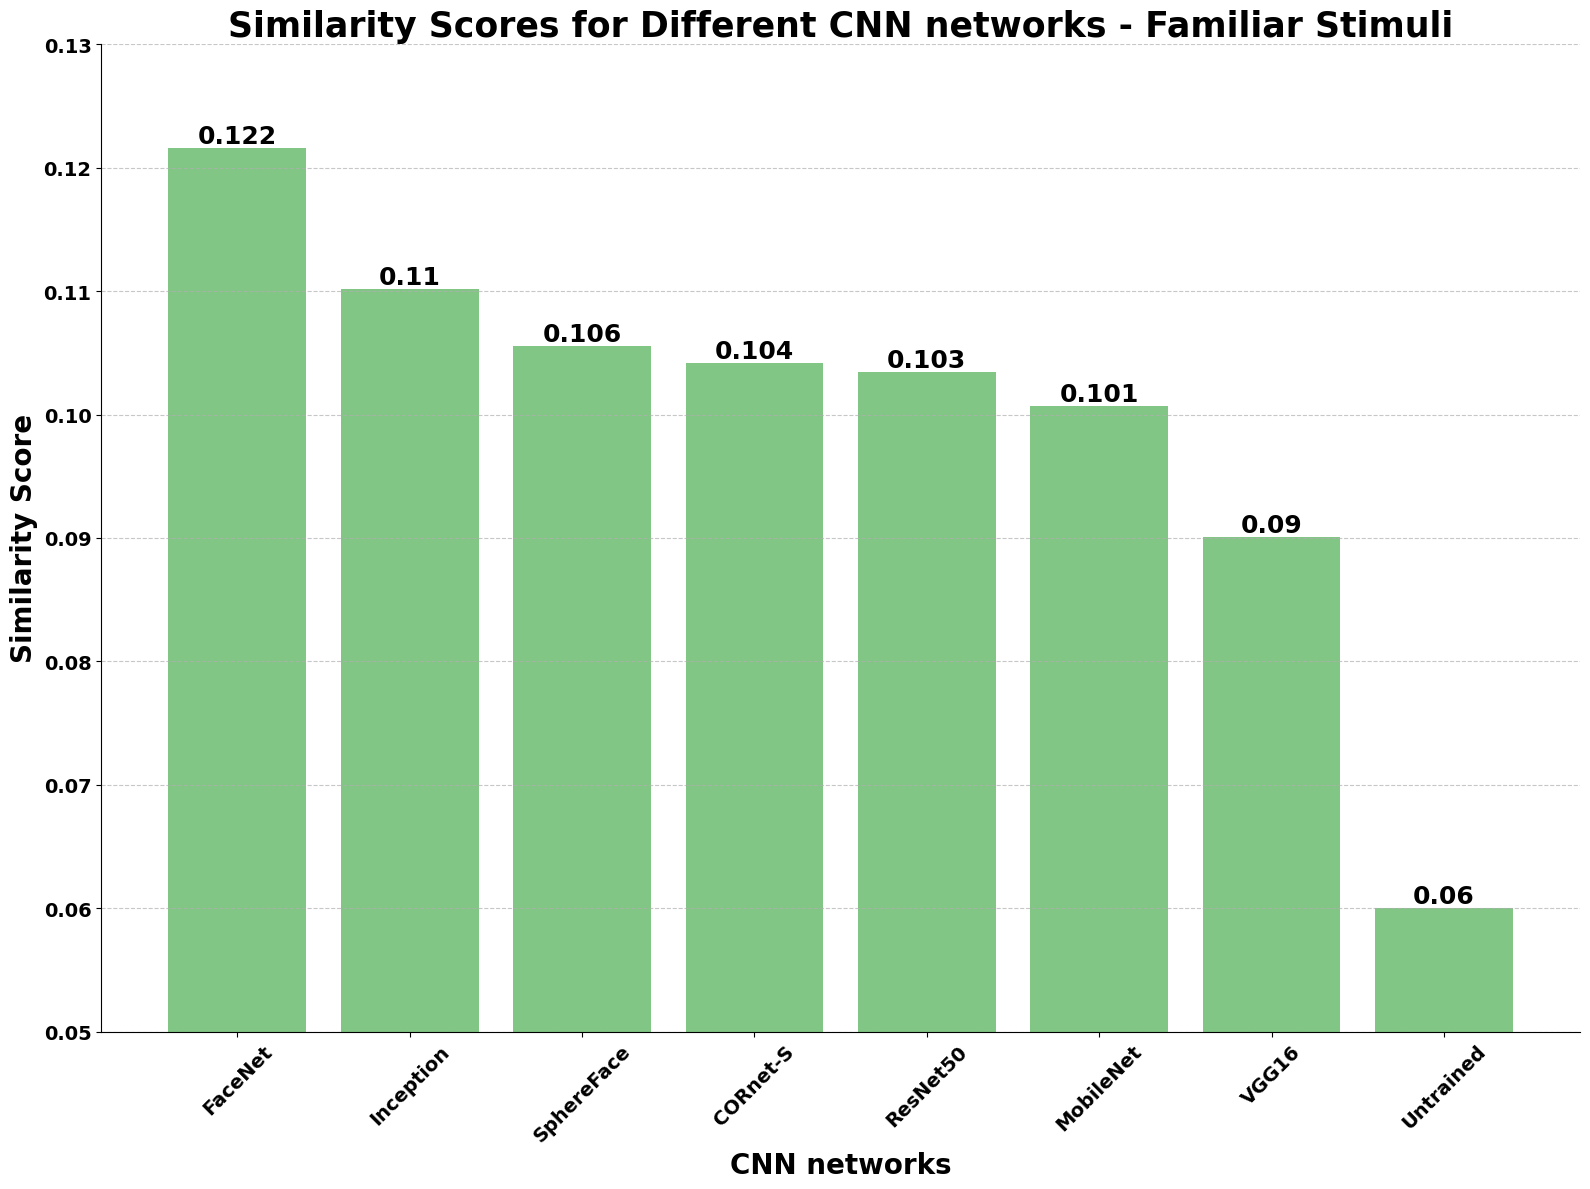

In [488]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
df = pd.DataFrame.from_dict(results, orient='index', columns=['Max Value', 'Max Index'])
df.loc['Untrained'] = [0.06, (1, 1, 1)]
# Sort DataFrame by 'Max Value' column in descending order
df = df.sort_values(by='Max Value', ascending=False)

# Replace model names
df = df.rename(index={'vgg16_bn': 'VGG16', 'cornet_s': 'CORnet-S', 'resnet50': 'ResNet50', 'mobilenet': 'MobileNet', 'inception_v3': 'Inception'})

# Set figure size
plt.figure(figsize=(16, 12))

# Bar plot with data labels
bars = plt.bar(df.index, df['Max Value'], color='#4CAF50', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=18, fontweight='bold')

# Set title and labels with increased font size
plt.title('Similarity Scores for Different CNN networks - Familiar Stimuli', fontsize=25, fontweight='bold')
plt.xlabel('CNN networks', fontsize=20, fontweight='bold')
plt.ylabel('Similarity Score', fontsize=20, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
# Remove right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits
plt.ylim(0.05, 0.13)

# Add tight layout
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('similarity_scores_different_CNN_Familiar.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

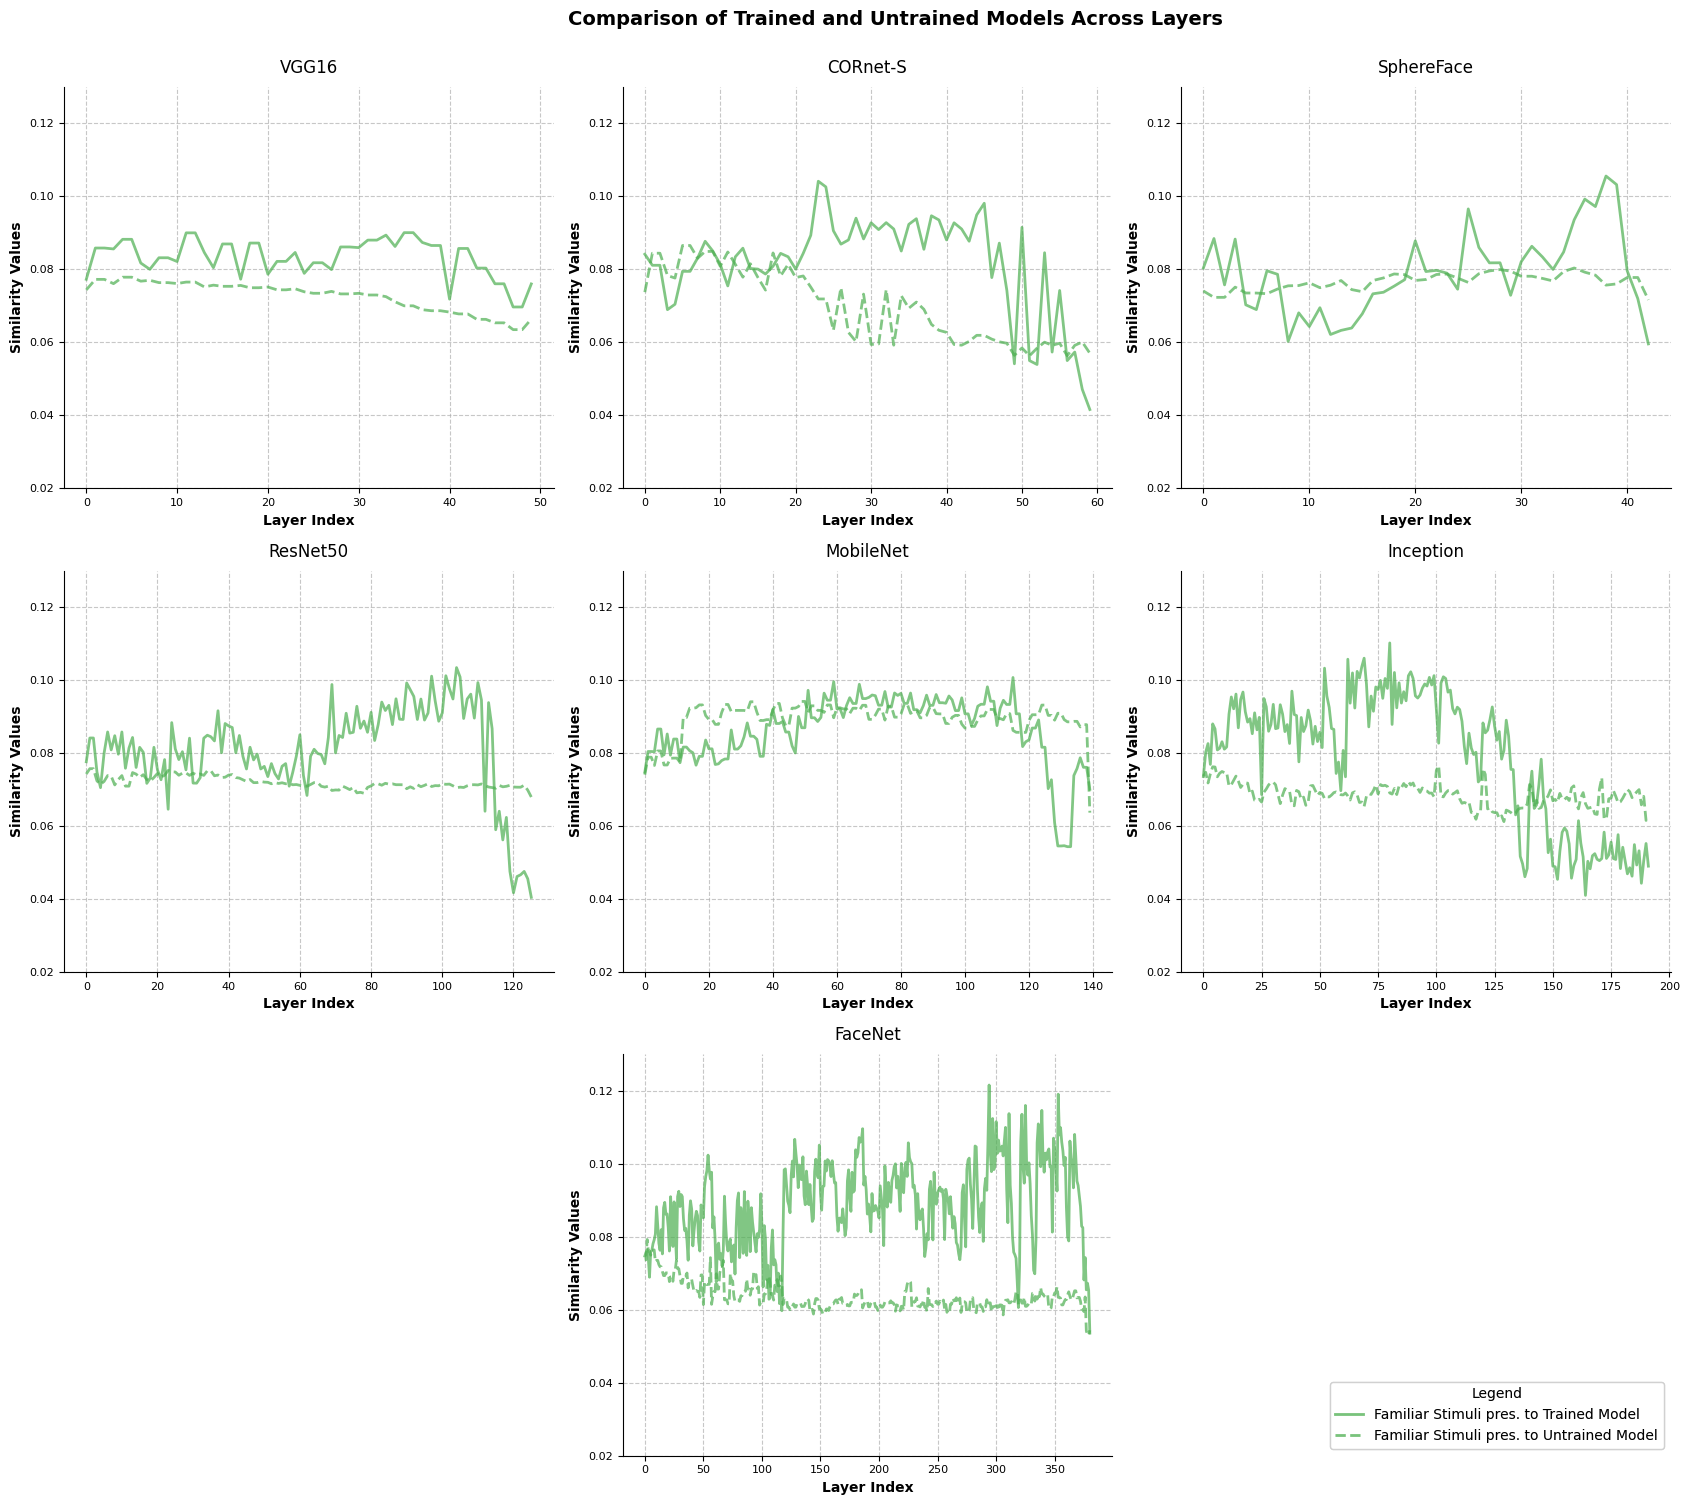

In [387]:
import os
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Sample data dictionary (replace this with your actual data)
models = ["vgg16_bn", "cornet_s", "SphereFace", "resnet50", "mobilenet", "inception_v3", "", "FaceNet"]
model_names = ["VGG16", "CORnet-S", "SphereFace", "ResNet50", "MobileNet", "Inception", "Untrained", "FaceNet"]

# Define markers for each model
markers = ['o', 's', 'D', '^', 'v', 'p', '*']

# Initialize the figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()  # Flatten the 2D array of subplots for easier iteration

for idx, (model, ax) in enumerate(zip(models, axs)):
    if idx == 6:
        continue
    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 3
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")

    ax.set_ylim(0.02, 0.13)
    # Add model description as a title to each subplot
    ax.set_title(model_names[idx], fontsize=12, loc='center', pad=10)
    
    ax.set_xlabel("Layer Index", fontsize=10, fontweight='bold')
    ax.set_ylabel("Similarity Values", fontsize=10, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Set main title
plt.suptitle("Comparison of Trained and Untrained Models Across Layers", fontsize=14, fontweight='bold', x=0.45, y=1)

# Move legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
axs[8].add_artist(plt.legend(handles, labels, loc='lower right', title="Legend"))
axs[8].spines['right'].set_visible(False)
axs[8].spines['top'].set_visible(False)
axs[8].spines['left'].set_visible(False)
axs[8].spines['bottom'].set_visible(False)
axs[8].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)  # Remove tick marks and values
fig.delaxes(axs[6])

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('comparison_familiar.png', dpi=300, bbox_inches='tight')
plt.show()


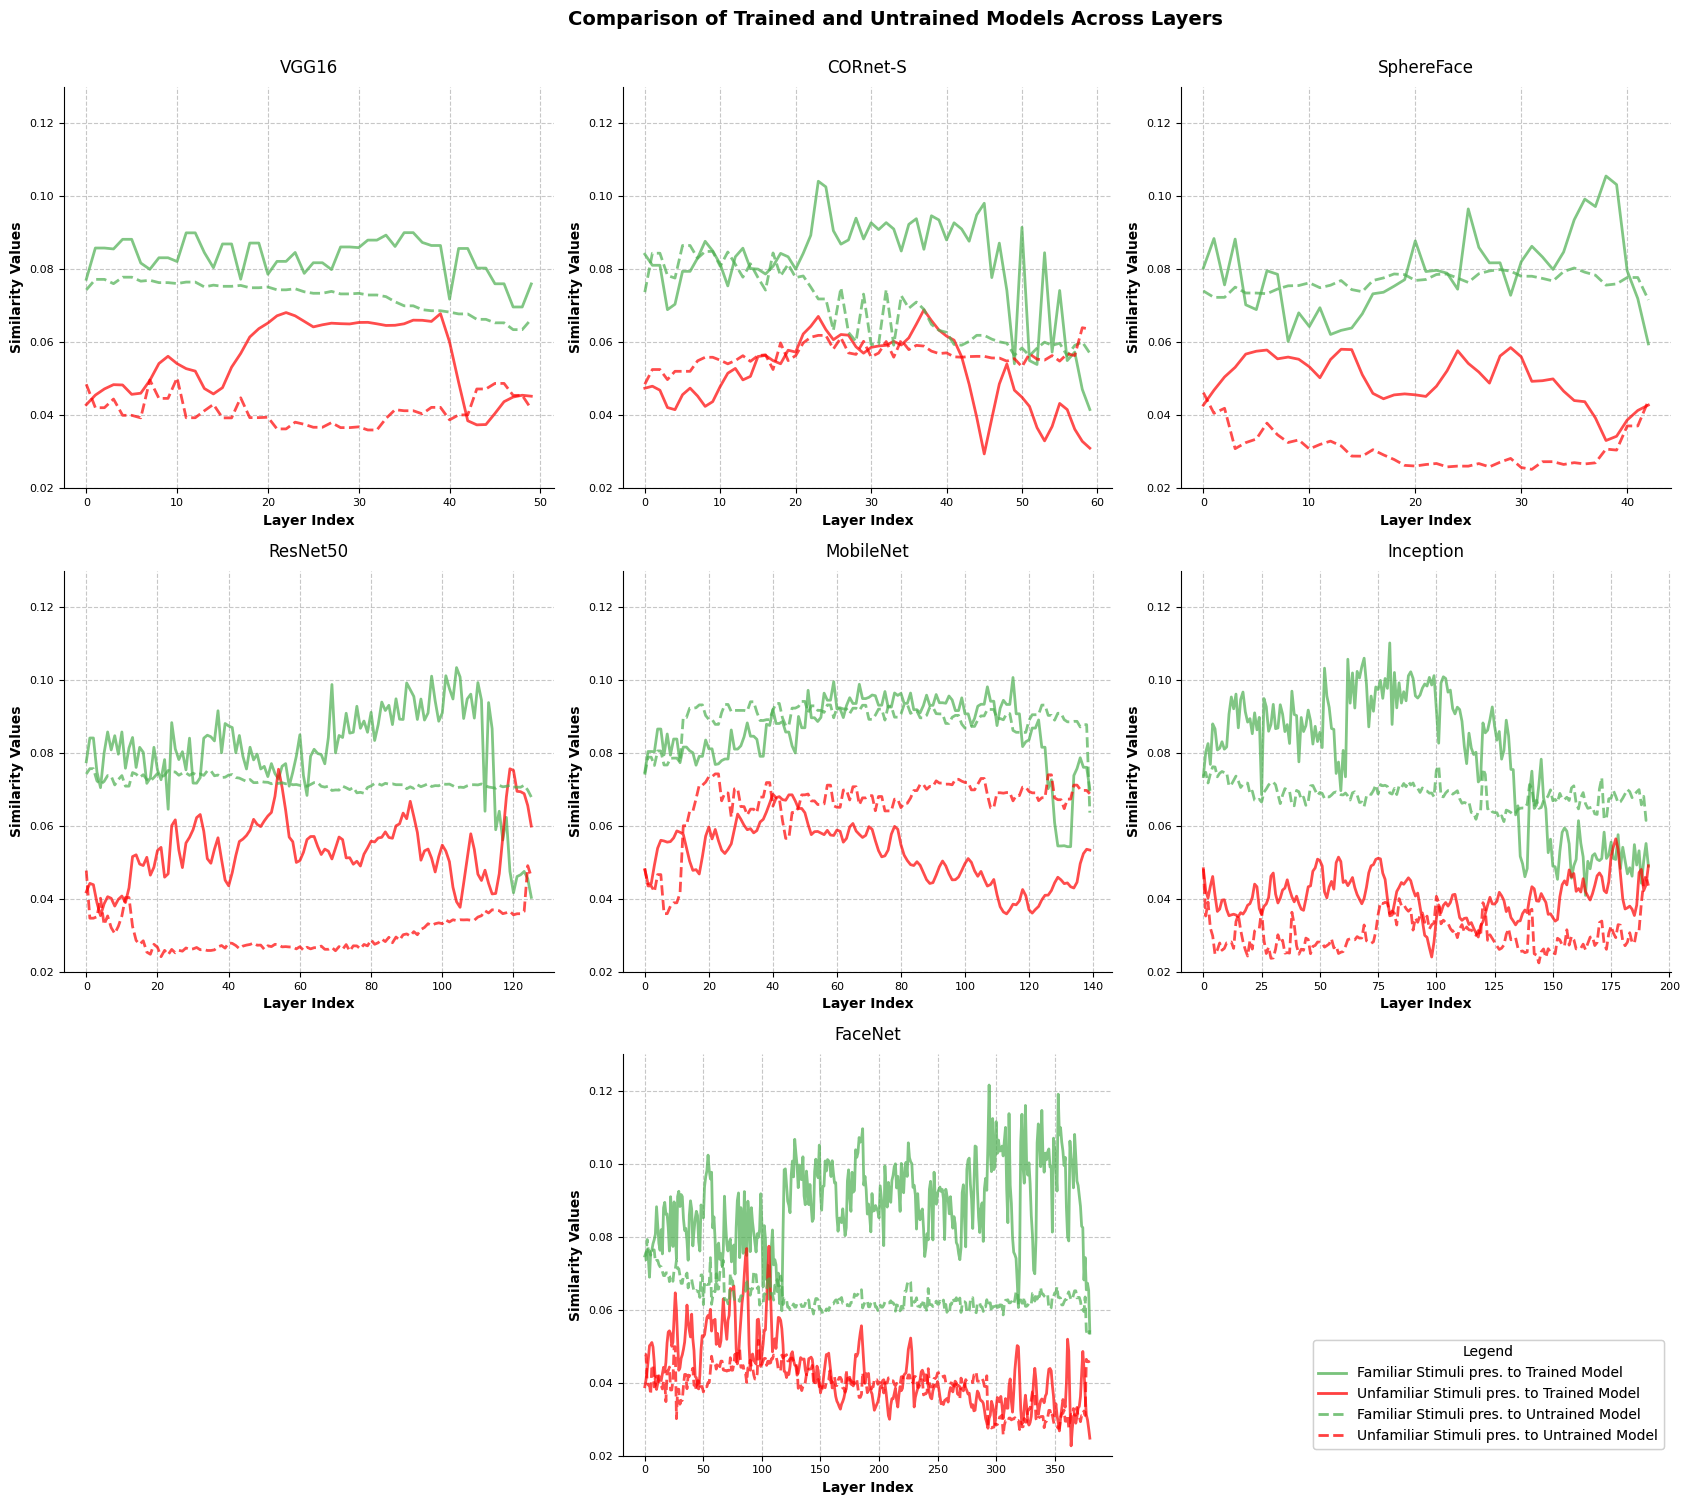

In [388]:
import os
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Sample data dictionary (replace this with your actual data)
models = ["vgg16_bn", "cornet_s", "SphereFace", "resnet50", "mobilenet", "inception_v3", "", "FaceNet"]
model_names = ["VGG16", "CORnet-S", "SphereFace", "ResNet50", "MobileNet", "Inception", "Untrained", "FaceNet"]

# Define markers for each model
markers = ['o', 's', 'D', '^', 'v', 'p', '*']

# Initialize the figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()  # Flatten the 2D array of subplots for easier iteration

for idx, (model, ax) in enumerate(zip(models, axs)):
    if idx == 6:
        continue
    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained_unfam.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")
    
    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained_unfam.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")

    ax.set_ylim(0.02, 0.13)
    # Add model description as a title to each subplot
    ax.set_title(model_names[idx], fontsize=12, loc='center', pad=10)
    
    ax.set_xlabel("Layer Index", fontsize=10, fontweight='bold')
    ax.set_ylabel("Similarity Values", fontsize=10, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Set main title
plt.suptitle("Comparison of Trained and Untrained Models Across Layers", fontsize=14, fontweight='bold', x=0.45, y=1)

# Move legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
axs[8].add_artist(plt.legend(handles, labels, loc='lower right', title="Legend"))
axs[8].spines['right'].set_visible(False)
axs[8].spines['top'].set_visible(False)
axs[8].spines['left'].set_visible(False)
axs[8].spines['bottom'].set_visible(False)
axs[8].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)  # Remove tick marks and values
fig.delaxes(axs[6])

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('comparison_familiar2.png', dpi=300, bbox_inches='tight')
plt.show()


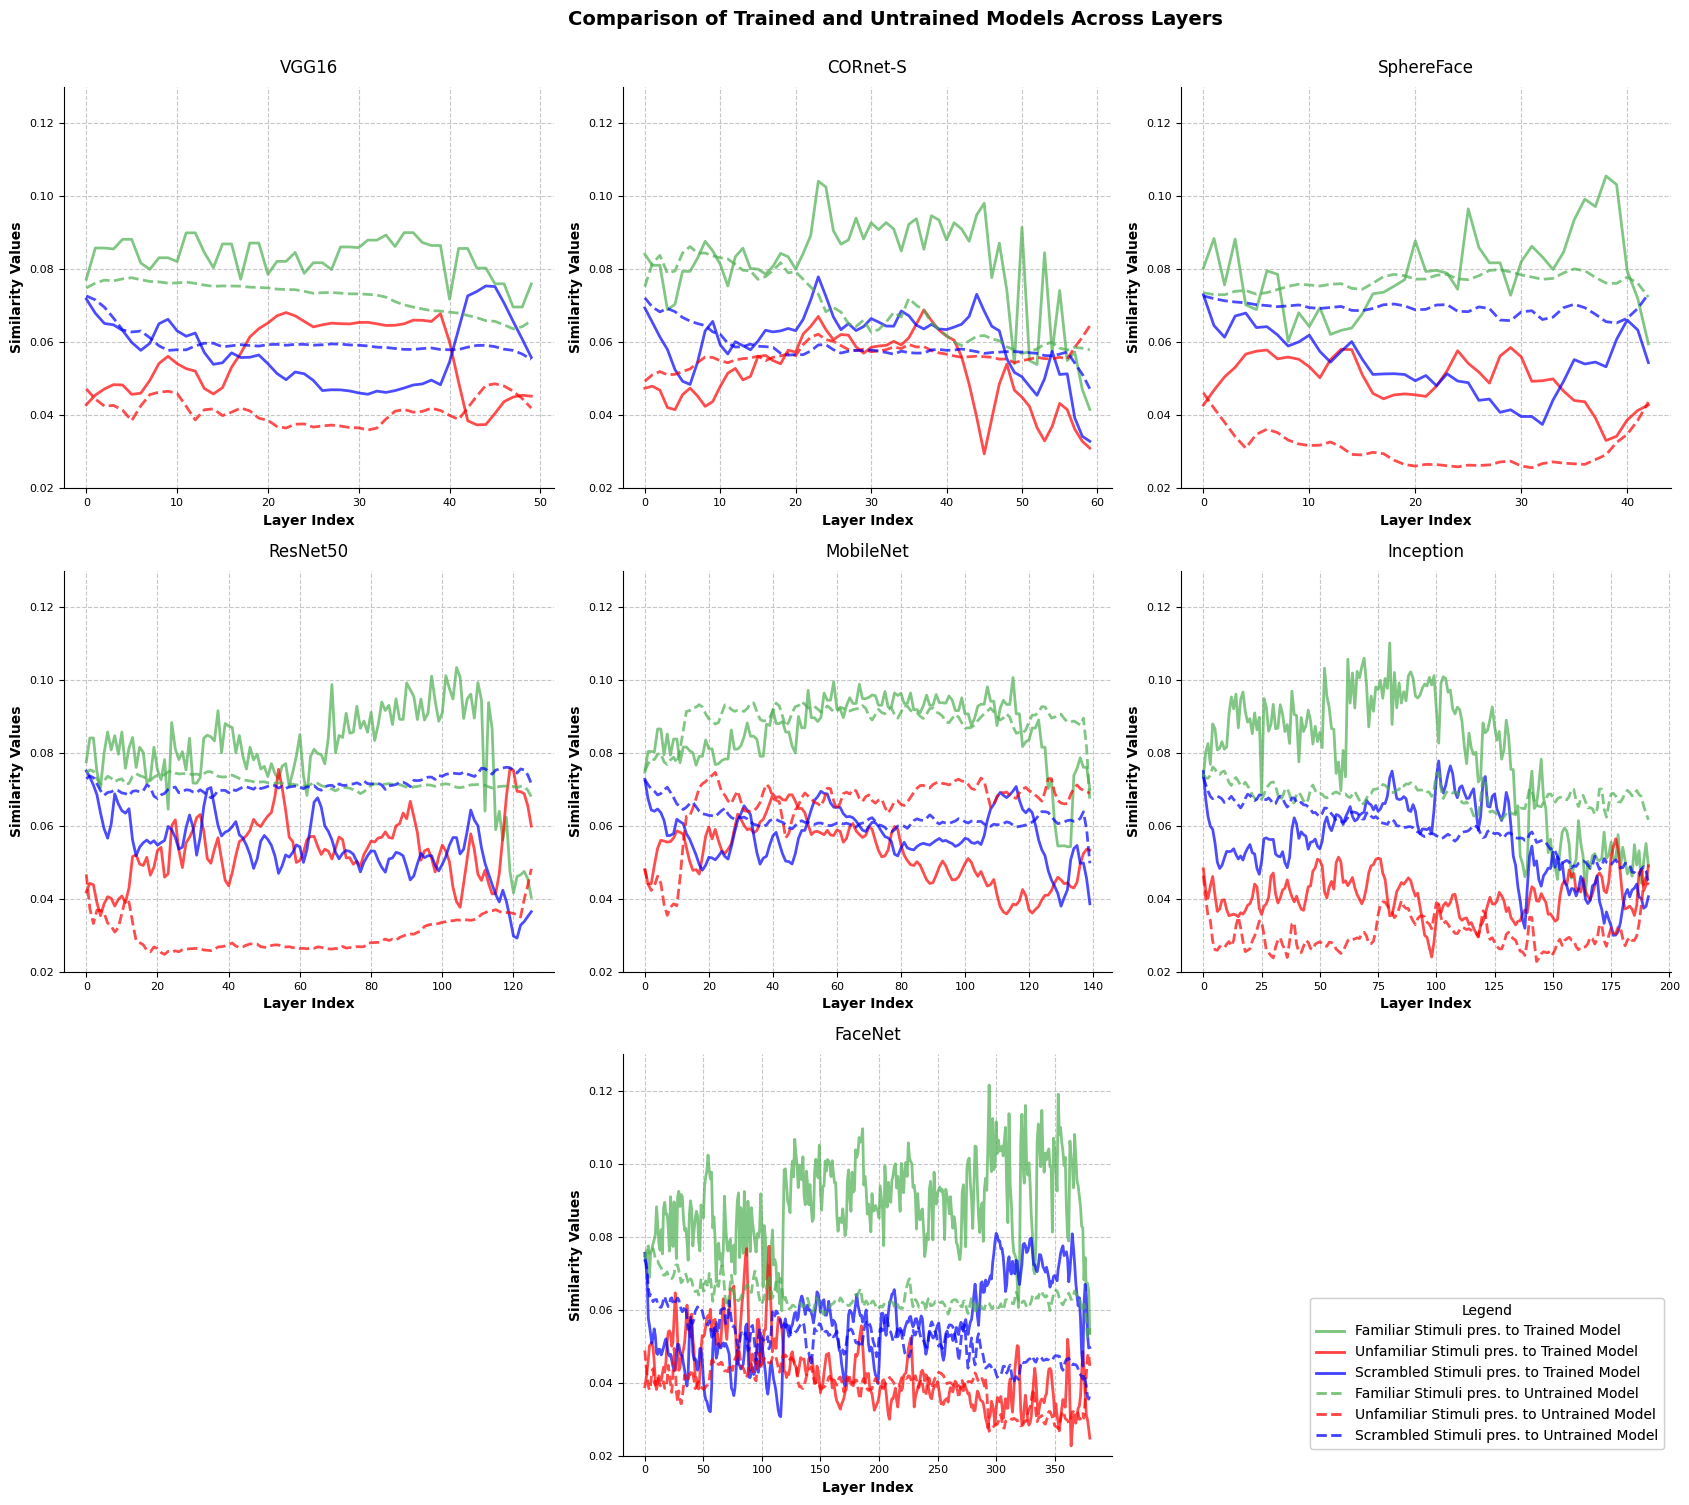

In [391]:
import os
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Sample data dictionary (replace this with your actual data)
models = ["vgg16_bn", "cornet_s", "SphereFace", "resnet50", "mobilenet", "inception_v3", "", "FaceNet"]
model_names = ["VGG16", "CORnet-S", "SphereFace", "ResNet50", "MobileNet", "Inception", "Untrained", "FaceNet"]

# Define markers for each model
markers = ['o', 's', 'D', '^', 'v', 'p', '*']

# Initialize the figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()  # Flatten the 2D array of subplots for easier iteration

for idx, (model, ax) in enumerate(zip(models, axs)):
    if idx == 6:
        continue
    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained_unfam.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")
    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained_scrambled.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, label="Scrambled Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")
    
    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained_unfam.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")

    
    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained_scrambled.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)

    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, linestyle='--', label="Scrambled Stimuli pres. to Untrained Model")


    

    ax.set_ylim(0.02, 0.13)
    # Add model description as a title to each subplot
    ax.set_title(model_names[idx], fontsize=12, loc='center', pad=10)
    
    ax.set_xlabel("Layer Index", fontsize=10, fontweight='bold')
    ax.set_ylabel("Similarity Values", fontsize=10, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Set main title
plt.suptitle("Comparison of Trained and Untrained Models Across Layers", fontsize=14, fontweight='bold', x=0.45, y=1)

# Move legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
axs[8].add_artist(plt.legend(handles, labels, loc='lower right', title="Legend"))
axs[8].spines['right'].set_visible(False)
axs[8].spines['top'].set_visible(False)
axs[8].spines['left'].set_visible(False)
axs[8].spines['bottom'].set_visible(False)
axs[8].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)  # Remove tick marks and values
fig.delaxes(axs[6])

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('comparison_familiar3.png', dpi=300, bbox_inches='tight')
plt.show()


In [60]:
def find_successive_indices(indices):
    successive_groups = []
    start = indices[0]
    for i in range(1, len(indices)):
        if indices[i] == indices[i - 1] + 1:
            continue
        end = indices[i - 1]
        successive_groups.append((start, end))
        start = indices[i]
    # Handle the last group
    successive_groups.append((start, indices[-1]))
    return successive_groups

In [64]:

from matplotlib.legend_handler import HandlerTuple, HandlerRegularPolyCollection

# Function to create a custom legend handler for the gray shaded area
class GrayLegendHandler(HandlerTuple):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        p = HandlerRegularPolyCollection().create_artists(
            legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
        )
        for patch in p:
            patch.set_color('gray')
            patch.set_alpha(0.3)
        return p

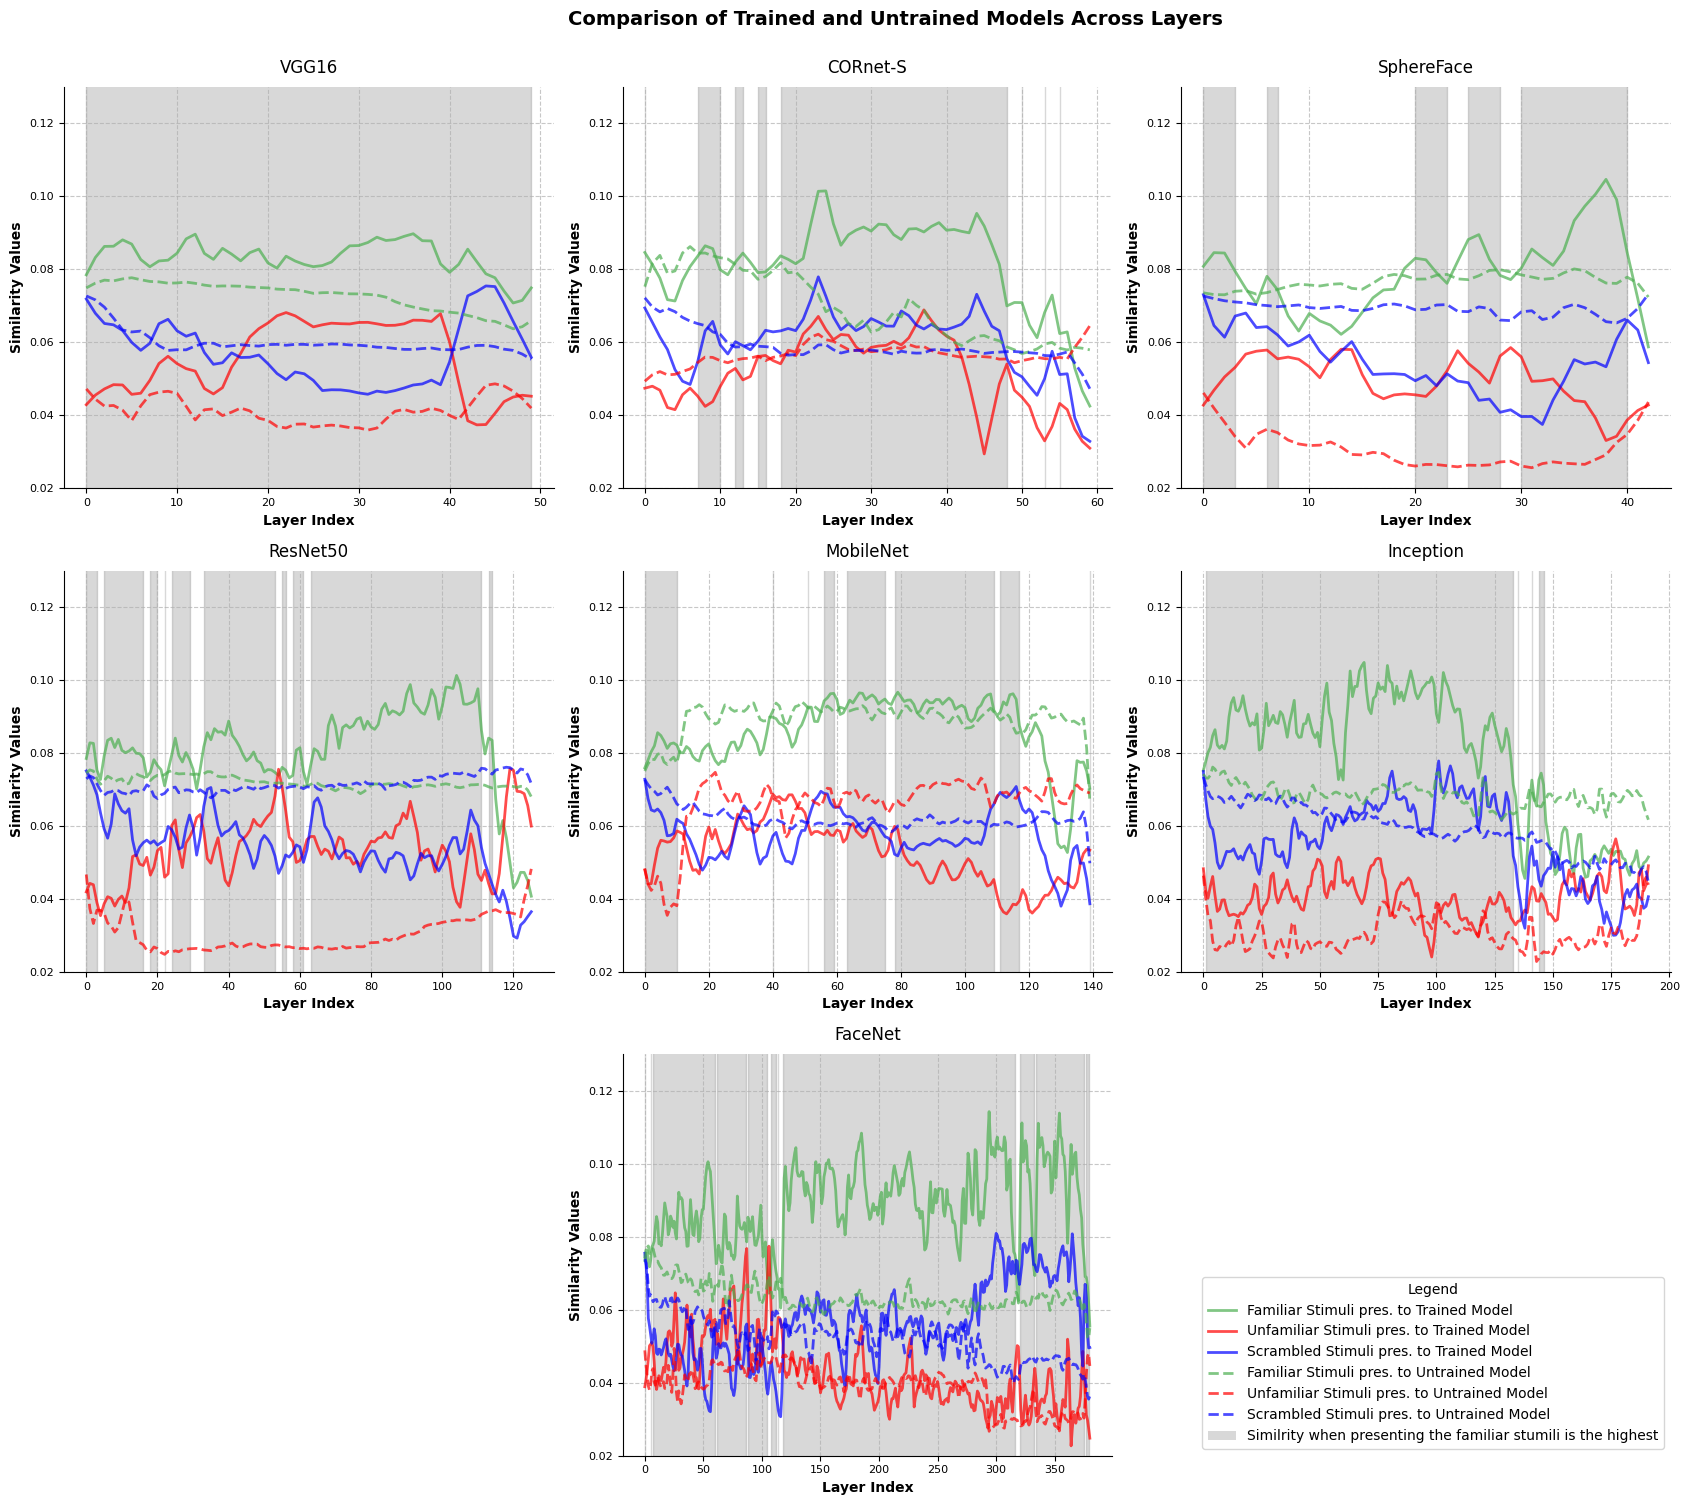

In [394]:
import os
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Sample data dictionary (replace this with your actual data)
models = ["vgg16_bn", "cornet_s", "SphereFace", "resnet50", "mobilenet", "inception_v3", "", "FaceNet"]
model_names = ["VGG16", "CORnet-S", "SphereFace", "ResNet50", "MobileNet", "Inception", "Untrained", "FaceNet"]

# Define markers for each model
markers = ['o', 's', 'D', '^', 'v', 'p', '*']

# Initialize the figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()  # Flatten the 2D array of subplots for easier iteration
for idx, (model, ax) in enumerate(zip(models, axs)):
    if idx == 6:
        continue
    list_of_max_values = []

    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)
    list_of_max_values.append(max_values)
    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained_unfam.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)
    list_of_max_values.append(max_values)
    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    color = '#4CAF50'  # Consistent color for trained and untrained lines

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")
    data_file = os.path.join(similarity_folder, f"avg_{model}_with-meg_pretrained_rdm_trained_scrambled.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)
    list_of_max_values.append(max_values)
    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, label="Scrambled Stimuli pres. to Trained Model")

    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)
    list_of_max_values.append(max_values)
    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")
    
    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained_unfam.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)
    list_of_max_values.append(max_values)
    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")
    

    data_file = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained_scrambled.npy")
    data = np.load(data_file)
    data[data[:, :, :, 1] > 0.05] = 0
    max_values = np.max(data[:, 2, :, 0], axis=0)
    list_of_max_values.append(max_values)
    window_size = 5
    smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 2)

    ax.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, linestyle='--', label="Scrambled Stimuli pres. to Untrained Model")

    # Iterate over the data points and find grey regions where Familiar Stimuli pres. to Trained Model is superior
    indices = [i for i, (val, v1, v2, v3, v4, v5) in enumerate(zip(list_of_max_values[0], list_of_max_values[1], 
                                                                   list_of_max_values[2], list_of_max_values[3], 
                                                                   list_of_max_values[4], list_of_max_values[5])) 
            if val > v1 and val > v2 and val > v3 and val > v4 and val > v5]
    successive_groups = find_successive_indices(indices)
    for start, end in successive_groups:
        # ax.axvline(x=start, color='grey', linestyle='--')
        # ax.axvline(x=end, color='grey', linestyle='--')
        ax.fill_between( np.arange(start, end+1), 0, 1, color='gray', alpha=0.3)

    ax.set_ylim(0.02, 0.13)
    # Add model description as a title to each subplot
    ax.set_title(model_names[idx], fontsize=12, loc='center', pad=10)
    
    ax.set_xlabel("Layer Index", fontsize=10, fontweight='bold')
    ax.set_ylabel("Similarity Values", fontsize=10, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Set main title
plt.suptitle("Comparison of Trained and Untrained Models Across Layers", fontsize=14, fontweight='bold', x=0.45, y=1)
# Add a custom legend for the gray shaded area
gray_patch = plt.Rectangle((0, 0), 1, 1, fc="gray", alpha=0.3, edgecolor='none')
# axs[6].add_patch(gray_patch)
axs[8].legend([gray_patch], ['Similrity when presenting the familiar stumili is the highest'], loc='upper left')

# Move legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
legend_handles = handles.copy()  # Handles from the first legend
legend_labels = labels.copy()    # Labels from the first legend
legend_handles.append(gray_patch)  # Handle for the gray legend
legend_labels.append('Similrity when presenting the familiar stumili is the highest')  # Label for the gray legend

# Add combined legend
axs[8].legend(legend_handles, legend_labels, loc='lower right', title="Legend")

axs[8].spines['right'].set_visible(False)
axs[8].spines['top'].set_visible(False)
axs[8].spines['left'].set_visible(False)
axs[8].spines['bottom'].set_visible(False)
axs[8].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)  # Remove tick marks and values
axs[6].spines['right'].set_visible(False)
axs[6].spines['top'].set_visible(False)
axs[6].spines['left'].set_visible(False)
axs[6].spines['bottom'].set_visible(False)
axs[6].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)  # Remove tick marks and values

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('comparison_familiar4.png', dpi=300, bbox_inches='tight')
plt.show()


In [84]:
## Take FACENET
## Add trained on object Recognition
## Add trained on object Recognition With A class for faces.


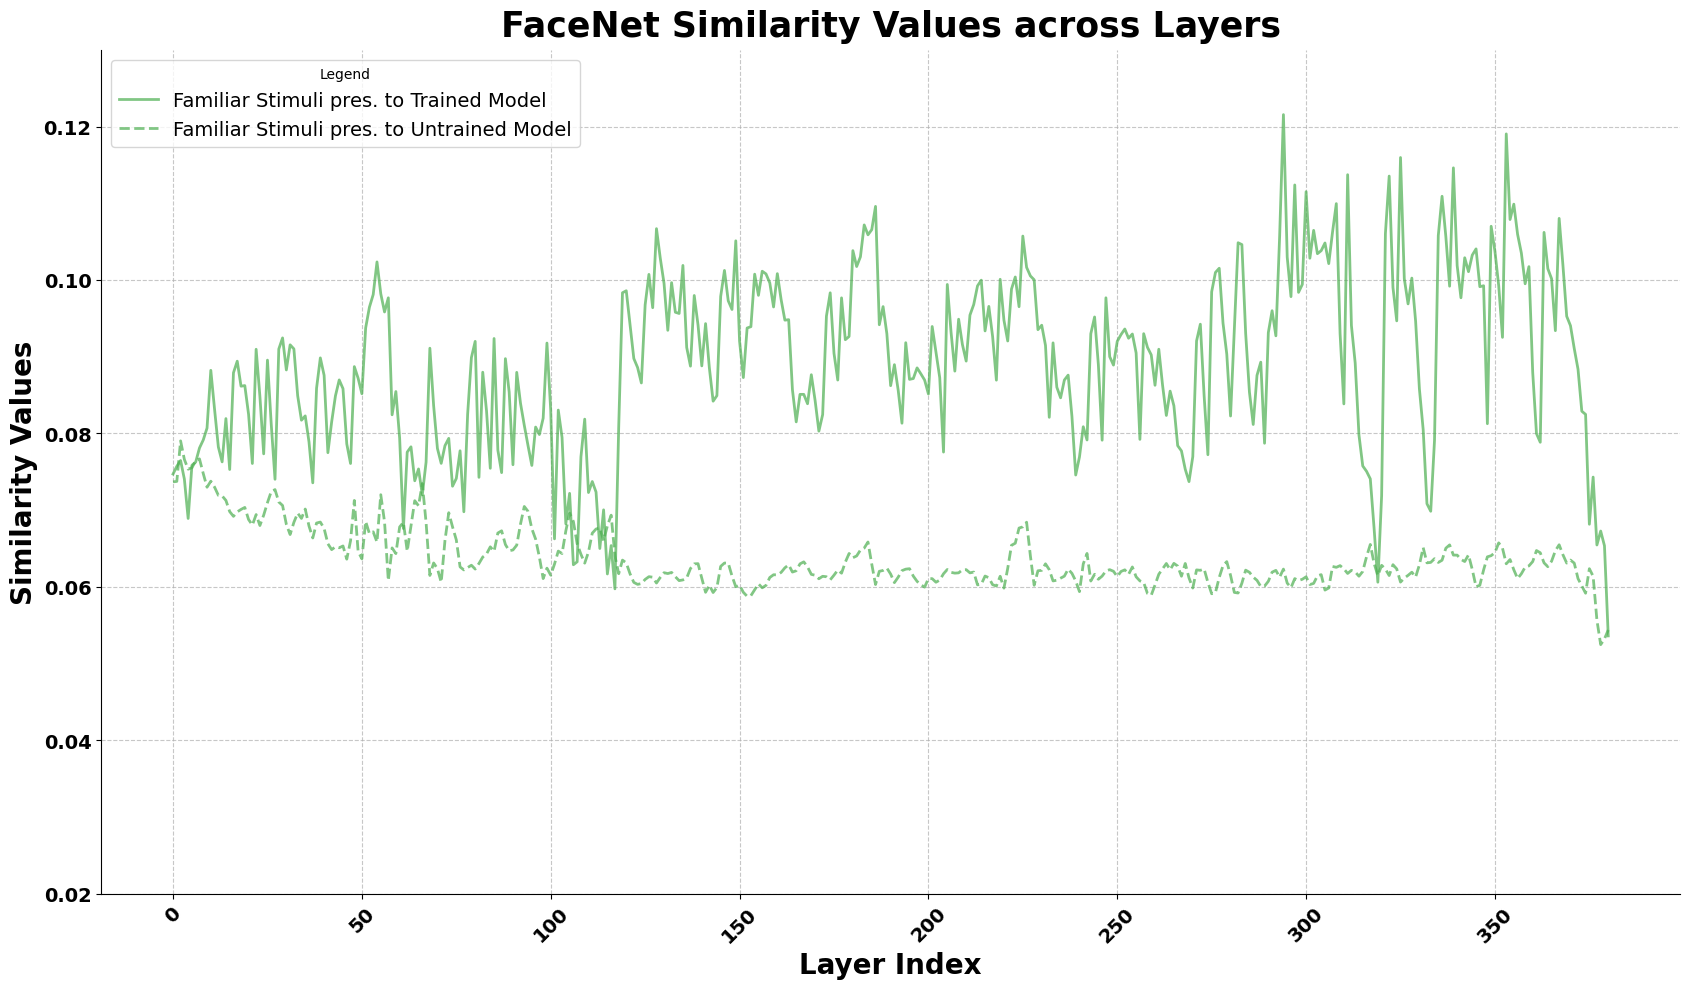

In [505]:
# Initialize the figure and subplots
fig, axs = plt.subplots(figsize=(20, 10))
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")

axs.set_ylim(0.02, 0.13)
# Add model description as a title to each subplot
axs.set_title("FaceNet Similarity Values across Layers", fontsize=25, loc='center', pad=10, fontweight='bold')
axs.set_xlabel("Layer Index", fontsize=20, fontweight='bold')
axs.set_ylabel("Similarity Values", fontsize=20, fontweight='bold')
axs.grid(True, linestyle='--', alpha=0.7)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', title="Legend", fontsize=14)
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('facenet1.png', dpi=300, bbox_inches='tight')
plt.show()


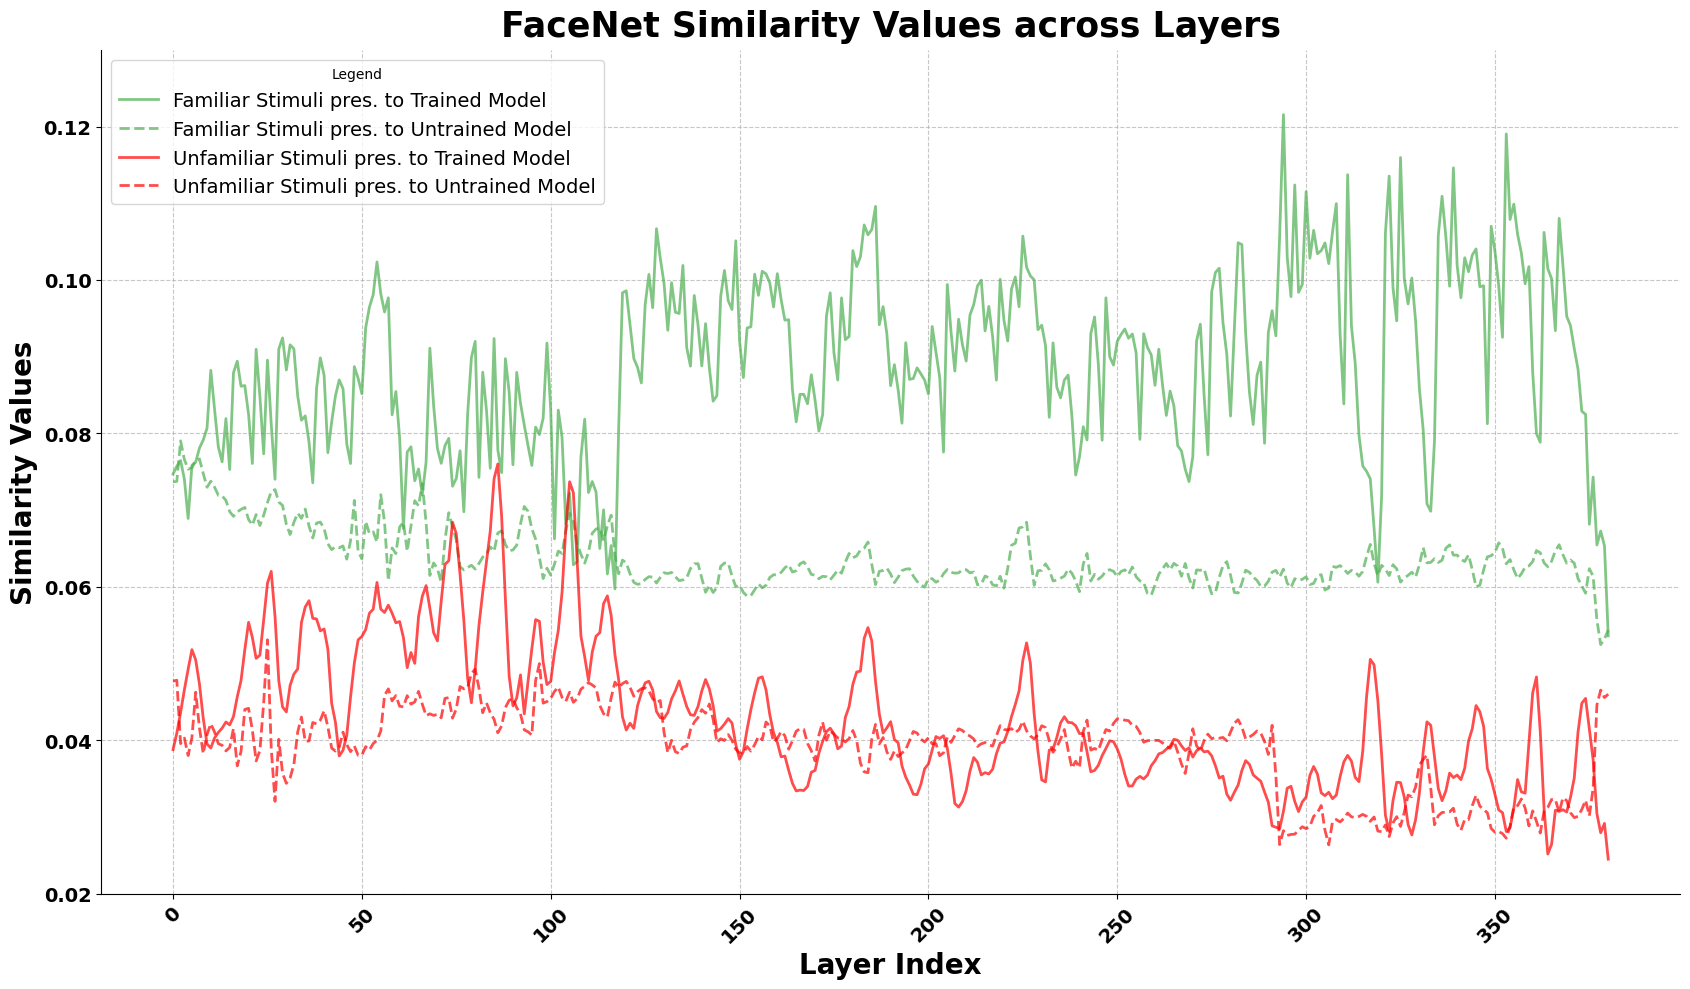

In [509]:
# Initialize the figure and subplots
fig, axs = plt.subplots(figsize=(20, 10))
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")
data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")

axs.set_ylim(0.02, 0.13)
# Add model description as a title to each subplot
axs.set_title("FaceNet Similarity Values across Layers", fontsize=25, loc='center', pad=10, fontweight='bold')
axs.set_xlabel("Layer Index", fontsize=20, fontweight='bold')
axs.set_ylabel("Similarity Values", fontsize=20, fontweight='bold')
axs.grid(True, linestyle='--', alpha=0.7)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', title="Legend", fontsize=14)
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('facenet2.png', dpi=300, bbox_inches='tight')
plt.show()


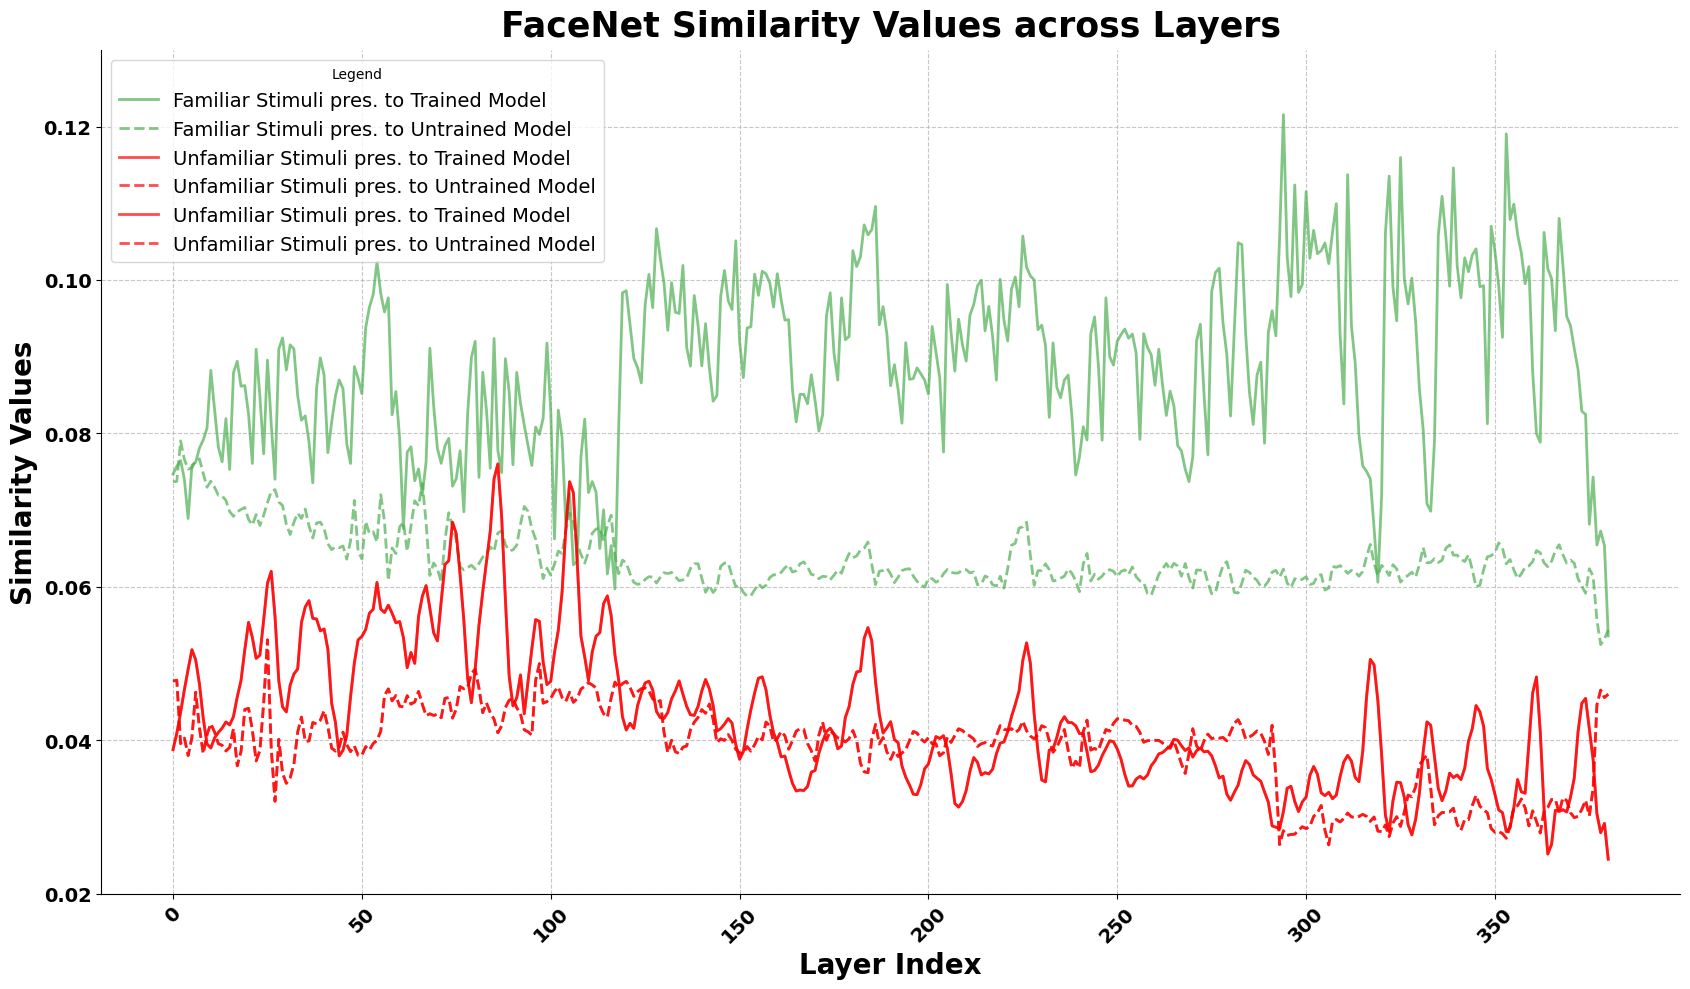

In [508]:
# Initialize the figure and subplots
fig, axs = plt.subplots(figsize=(20, 10))
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")
data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")
data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")

axs.set_ylim(0.02, 0.13)
# Add model description as a title to each subplot
axs.set_title("FaceNet Similarity Values across Layers", fontsize=25, loc='center', pad=10, fontweight='bold')
axs.set_xlabel("Layer Index", fontsize=20, fontweight='bold')
axs.set_ylabel("Similarity Values", fontsize=20, fontweight='bold')
axs.grid(True, linestyle='--', alpha=0.7)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper left', title="Legend", fontsize=14)
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('facenet2.png', dpi=300, bbox_inches='tight')
plt.show()


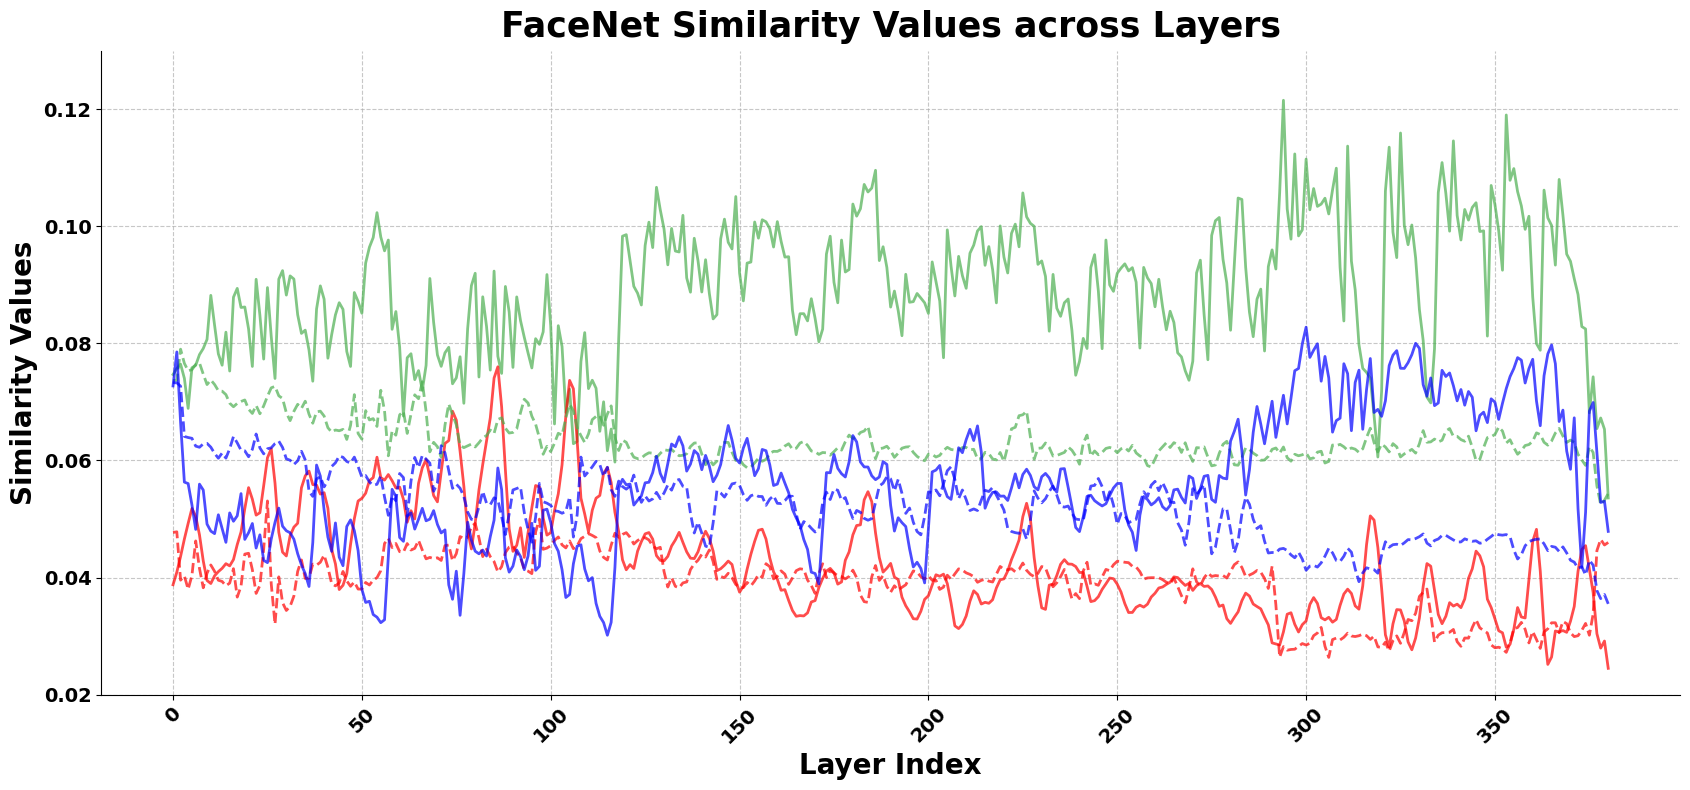

In [498]:
# Initialize the figure and subplots
fig, axs = plt.subplots(figsize=(20, 8))
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")
    
data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_scrambled.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, label="Scrambled Stimuli pres. to Trained Model")
    

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_scrambled.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, linestyle='--', label="Scrambled Stimuli pres. to Untrained Model")


axs.set_ylim(0.02, 0.13)
# Add model description as a title to each subplot
axs.set_title("FaceNet Similarity Values across Layers", fontsize=25, loc='center', pad=10, fontweight='bold')
axs.set_xlabel("Layer Index", fontsize=20, fontweight='bold')
axs.set_ylabel("Similarity Values", fontsize=20, fontweight='bold')
axs.grid(True, linestyle='--', alpha=0.7)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('publication_plot.png', dpi=300, bbox_inches='tight')
plt.show()


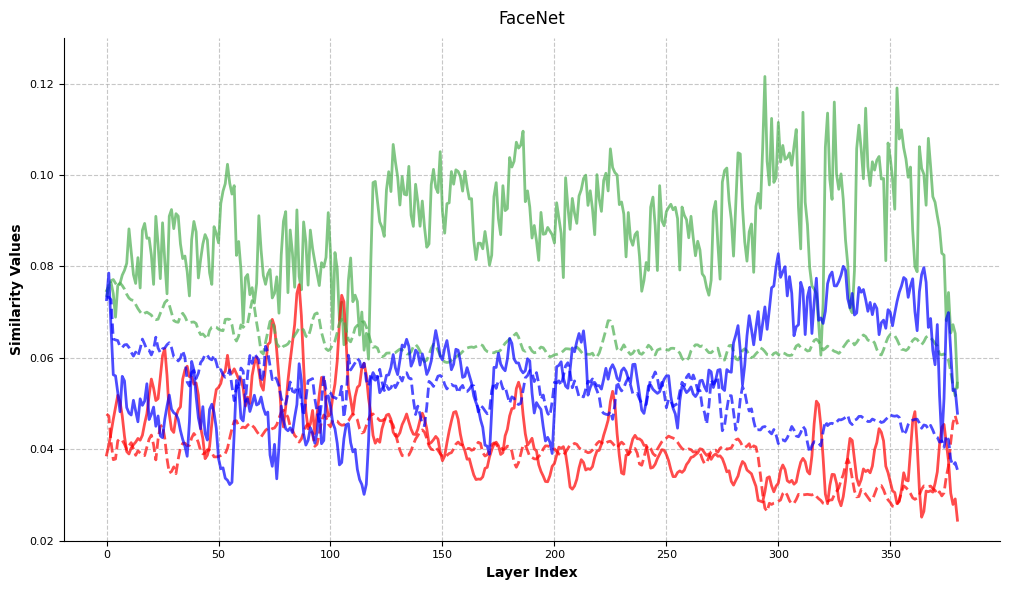

In [495]:

# Initialize the figure and subplots
fig, axs = plt.subplots(figsize=(12, 6))
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), max_values, linewidth=2.0, color=color, alpha=0.7, label="Familiar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

color = '#4CAF50'  # Consistent color for trained and untrained lines

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Trained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color=color, alpha=0.7, label="Familiar Stimuli pres. to Untrained Model")
    
data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_unfam.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 5)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, linestyle='--', color="red", alpha=0.7, label="Unfamiliar Stimuli pres. to Untrained Model")

data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained_scrambled.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, label="Scrambled Stimuli pres. to Trained Model")
    

data_file = os.path.join(similarity_folder, f"avg_FaceNet_None_rdm_untrained_scrambled.npy")
data = np.load(data_file)
data[data[:, :, :, 1] > 0.05] = 0
max_values = np.max(data[:, 2, :, 0], axis=0)
list_of_max_values.append(max_values)
window_size = 10
smoothed_values = scipy.signal.savgol_filter(max_values, window_size, 8)

axs.plot(np.arange(0, len(max_values)), smoothed_values, linewidth=2.0, color="blue", alpha=0.7, linestyle='--', label="Scrambled Stimuli pres. to Untrained Model")


axs.set_ylim(0.02, 0.13)
# Add model description as a title to each subplot
axs.set_title(model_names[idx], fontsize=12, loc='center', pad=10)

axs.set_xlabel("Layer Index", fontsize=10, fontweight='bold')
axs.set_ylabel("Similarity Values", fontsize=10, fontweight='bold')
axs.grid(True, linestyle='--', alpha=0.7)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=8)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot area to fit the legend

# Save the plot
plt.savefig('publication_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [89]:
## Present Unfamiliar Stimuli

In [90]:
## Present Scrambled Stimuli

In [91]:
## Replicate all anaylsis with using random faces in the training: Familiar Stimuli not included in the training set.

In [92]:
## Study Effect of Time:

In [480]:
results = {}
data_file = os.path.join(similarity_folder, f"avg_FaceNet_with-meg_pretrained_rdm_trained.npy")
data = np.load(data_file)

for i, time_segment in enumerate(["0-500ms", "50-550ms", "100-600ms", "150-650ms", "200-700ms", "250-750ms", "300-800ms"]):
    max_val = np.max(data[:, i, :, 0])
    max_index = np.unravel_index(np.argmax(data[:, :, :, 0]), data[:, :, :, 0].shape)
    results[time_segment] = (max_val, max_index)
    print(f"{time_segment}: {max_val} at {max_index}")

0-500ms: 0.09857126900607016 at (119, 2, 294)
50-550ms: 0.11394745899088744 at (119, 2, 294)
100-600ms: 0.12155989861156848 at (119, 2, 294)
150-650ms: 0.09051591912642999 at (119, 2, 294)
200-700ms: 0.08150758318601997 at (119, 2, 294)
250-750ms: 0.07674146282740094 at (119, 2, 294)
300-800ms: 0.09054225434679428 at (119, 2, 294)


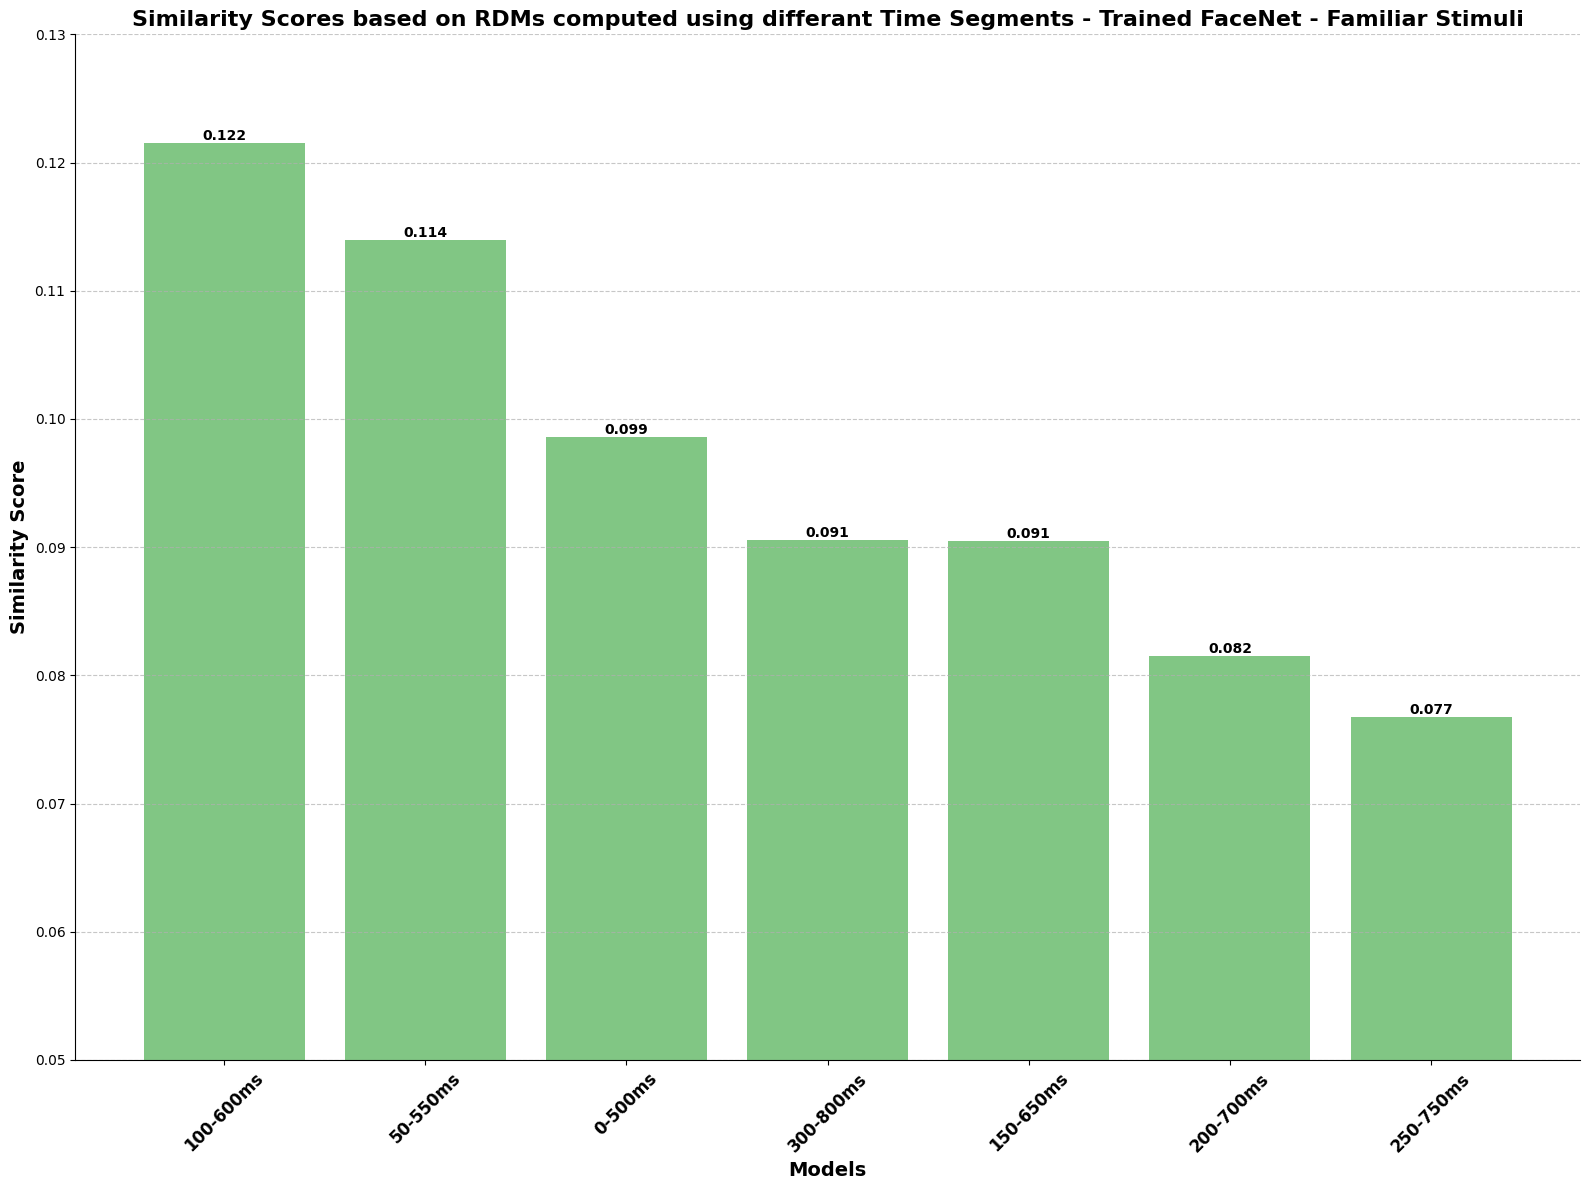

In [483]:
import pandas as pd

# Sample data
df = pd.DataFrame.from_dict(results, orient='index', columns=['Max Value', 'Max Index'])
# Sort DataFrame by 'Max Value' column in descending order
df = df.sort_values(by='Max Value', ascending=False)

# Replace model names
# Set figure size
plt.figure(figsize=(16, 12))

# Bar plot with data labels
bars = plt.bar(df.index, df['Max Value'], color='#4CAF50', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set title and labels with increased font size
plt.title('Similarity Scores based on RDMs computed using differant Time Segments - Trained FaceNet - Familiar Stimuli', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Similarity Score', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, fontweight='bold')

# Remove right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits
plt.ylim(0.05, 0.13)

# Add tight layout
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('time_seg.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [111]:
# What about the regions

In [306]:
import mne
from matplotlib import colormaps
from mne.viz import Brain
cmap= colormaps["bwr"]
rois = mne.read_labels_from_annot(parc='aparc_sub', subject='fsaverage', subjects_dir=subjects_dir)

Reading labels from parcellation...
   read 226 labels from /Users/hamzaabdelhedi/Projects/data/MFRS_data/subjects/fsaverage/label/lh.aparc_sub.annot
   read 224 labels from /Users/hamzaabdelhedi/Projects/data/MFRS_data/subjects/fsaverage/label/rh.aparc_sub.annot


In [397]:
# data_file = os.path.join(path, "avg_cornet_s_without-meg_pretrained_rdm_trained.npy")

# data = np.load(data_file)
model ="FaceNet"
analysis =   "with-meg_pretrained"
data_file = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
data = np.load(data_file)
# data[data[:, :, :, 1] > 0.05] = 0
values = np.max(data[:, 2, :, 0], axis=1)
max_val = 0.1215

In [398]:
brain = Brain(
        subject='fsaverage', subjects_dir=subjects_dir, surf="inflated", hemi="split",  background='white', size=(800, 400)
)
labels_lh = np.zeros(len(brain.geo["lh"].coords), dtype=int)
labels_rh = np.zeros(len(brain.geo["rh"].coords), dtype=int)
ctab_lh = list()
ctab_rh = list()
for i, (roi, value) in enumerate(zip(rois, values), 1):
    if roi.hemi == "lh":
        labels = labels_lh
        ctab = ctab_lh
    else:
        labels = labels_rh
        ctab = ctab_rh
    labels[roi.vertices] = i
    if roi.name in ["unknown-rh", "unknown-lh"]  or value == 0:
        ctab.append([128, 128, 128, 255, i])
    else:
        ctab.append([int(x * 255) for x in cmap(value / max_val)[:4]] + [i])

ctab_lh = np.array(ctab_lh)
ctab_rh = np.array(ctab_rh)

Context leak detected, msgtracer returned -1


In [399]:
brain.add_annotation(
[(labels_lh, ctab_lh), (labels_rh, ctab_rh)], borders=False, alpha=1.0, remove_existing=True
)
brain.show_view() #caudal, ventral 

In [400]:
# Get screenshot and crop it
screenshot = brain.screenshot()
nonwhite_pix = (screenshot != 255).any(-1)
nonwhite_row = nonwhite_pix.any(1)
nonwhite_col = nonwhite_pix.any(0)
cropped_screenshot = screenshot[nonwhite_row][:, nonwhite_col]


In [198]:
# list_views = []

In [402]:
list_views[-1]=cropped_screenshot

In [395]:
import pickle

# Load the list from the file
with open('list_views.pkl', 'rb') as f:
    list_views = pickle.load(f)


In [168]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


In [396]:
len(list_views)

12

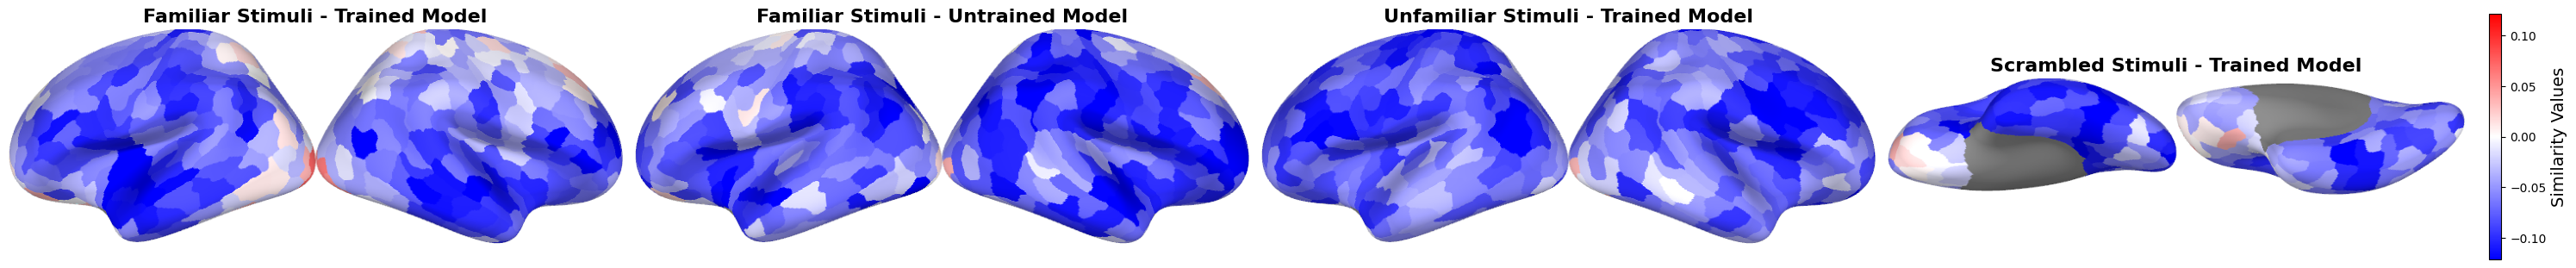

In [403]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from pyvista import plot

# Assuming 'list_views' is a list containing three pyvista_ndarray objects representing screenshots
# Create subplots with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(30, 10))

# Iterate through the list of images and plot them in separate subplots
for i, image_id in enumerate([0, 3, 6, 9]):
    # Use plt.imshow() to display the image in the current subplot
    axs[i].imshow(list_views[image_id], cmap='gray')  # You can customize the colormap if needed
    axs[i].set_title(f'Image {image_id}')  # Set a title for each subplot if desired
    axs[i].axis('off')  # Turn off axis for cleaner visualization

# Add labels for each subplot
axs[0].set_title('Familiar Stimuli - Trained Model', fontsize=16, fontweight='bold')
axs[1].set_title('Familiar Stimuli - Untrained Model', fontsize=16, fontweight='bold')
axs[2].set_title('Unfamiliar Stimuli - Trained Model', fontsize=16, fontweight='bold')
axs[3].set_title('Scrambled Stimuli - Trained Model', fontsize=16, fontweight='bold')

# Create a colormap and normalization for the color bar
max_val = 0.1215  # Specify the maximum value for normalization

# Add color bar for the fourth subplot
norm = Normalize(vmin=-max_val, vmax=max_val)
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axs[3], fraction=0.02, pad=0.04)  # You can adjust the position of the color bar

# Set color bar label and adjust font size
cbar.set_label('Similarity Values', fontsize=14)  # Add your specific color bar label here

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [304]:
len(list_views)

12

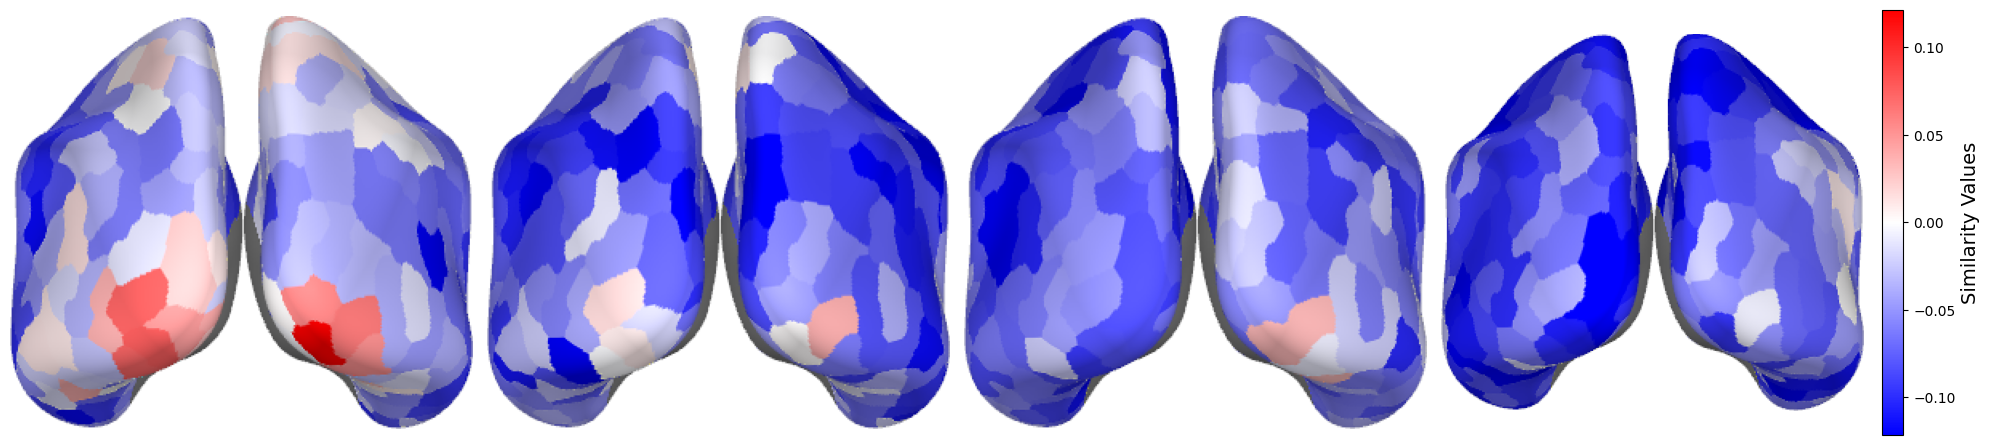

In [317]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Assuming 'list_views' is a list containing three pyvista_ndarray objects representing screenshots
# Create subplots with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Iterate through the list of images and plot them in separate subplots
for i, image_id in enumerate([1, 4, 7, 10]):
    # Use plt.imshow() to display the image in the current subplot
    im = axs[i].imshow(list_views[image_id], cmap=cmap)  # You can customize the colormap if needed
    axs[i].axis('off')  # Turn off axis for cleaner visualization

# Create a colormap and normalization for the color bar

# Add color bar for the fourth subplot
norm = Normalize(vmin=-max_val, vmax=max_val)
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axs[3], fraction=0.046, pad=0.04)  # You can adjust the position of the color bar

# Set color bar label and adjust font size
cbar.set_label('Similarity Values', fontsize=14)  # Add your specific color bar label here

# Set main title

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


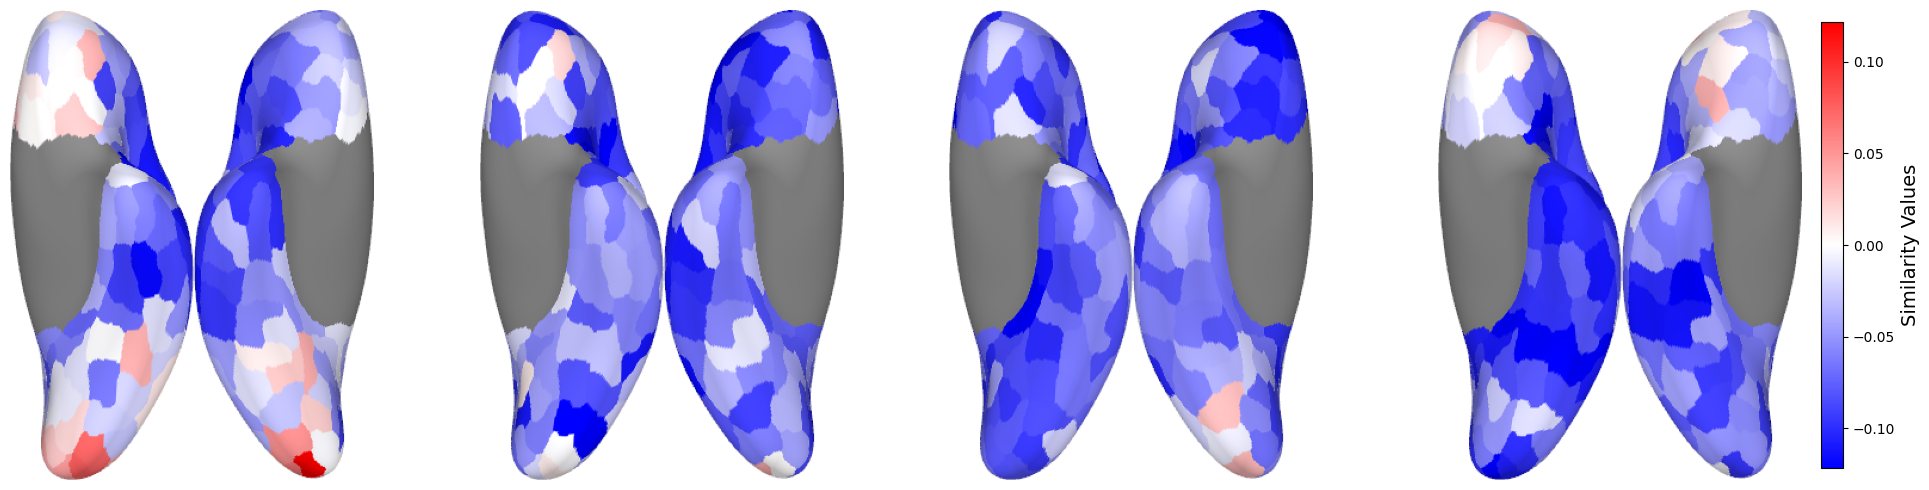

In [319]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Assuming 'list_views' is a list containing three pyvista_ndarray objects representing screenshots
# Create subplots with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Iterate through the list of images and plot them in separate subplots
for i, image_id in enumerate([2, 5, 8, 11]):
    # Use plt.imshow() to display the image in the current subplot
    axs[i].imshow(list_views[image_id], cmap='gray')  # You can customize the colormap if needed
    axs[i].axis('off')  # Turn off axis for cleaner visualization

# Create a colormap and normalization for the color bar
# Add color bar for the fourth subplot
norm = Normalize(vmin=-max_val, vmax=max_val)
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axs[3], fraction=0.046, pad=0.04)  # You can adjust the position of the color bar

# Set color bar label and adjust font size
cbar.set_label('Similarity Values', fontsize=14)  # Add your specific color bar label here

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [320]:
# Select fusiform gyrus

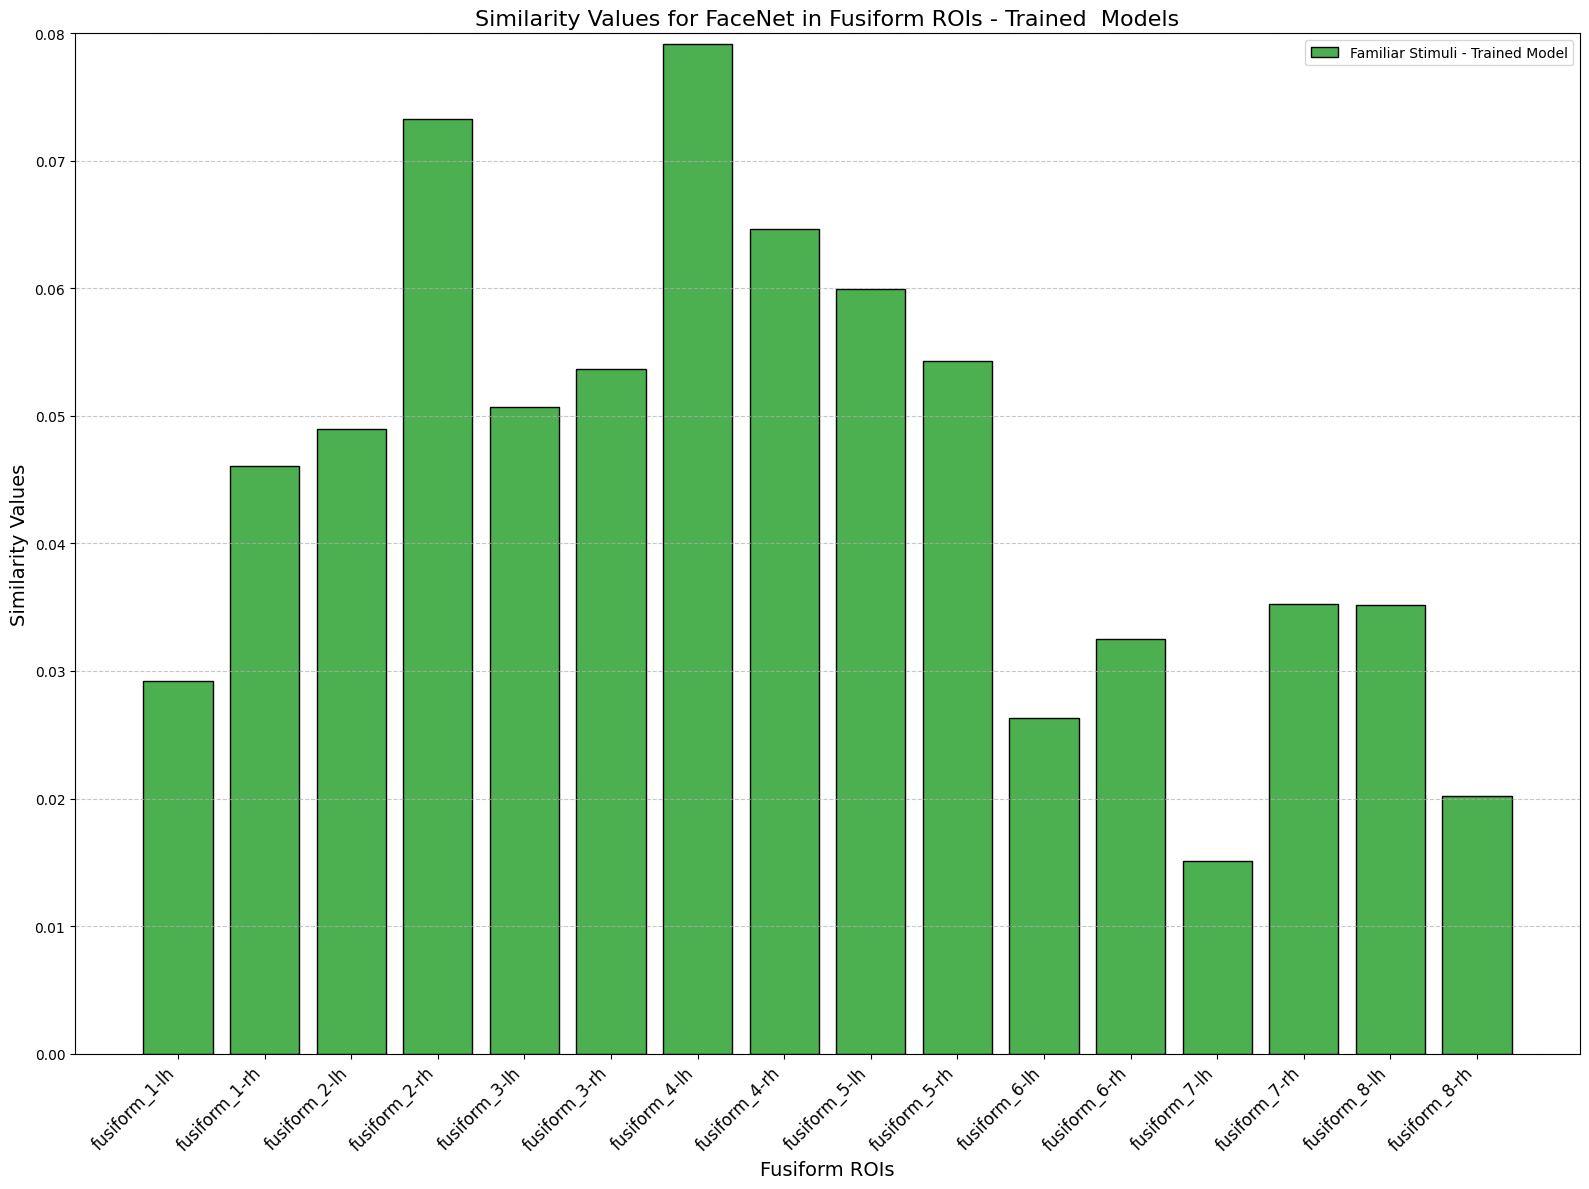

In [414]:
# Given model and analysis for unfamilar stimuli
model = "FaceNet"
analysis = "with-meg_pretrained"
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

# Plotting the bar chart for unfamiliar stimuli in light green
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the bar chart for familiar stimuli in sky blue with reduced width for better visualization
# ax.bar(np.arange(len(fusiform_labels)), values_untrained[fusiform_labels], color='white', edgecolor='red', hatch='\\', width=0.4, label='Familiar Stimuli - Untrained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)))
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20)
ax.set_xlabel('Fusiform ROIs', fontsize=20)
ax.set_title(f'Similarity Values for {model} in Fusiform ROIs - Trained  Models', fontsize=16)
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Save or display the plot
plt.tight_layout()
plt.savefig('fusiform_trained.png', dpi=300, bbox_inches='tight')
plt.show()


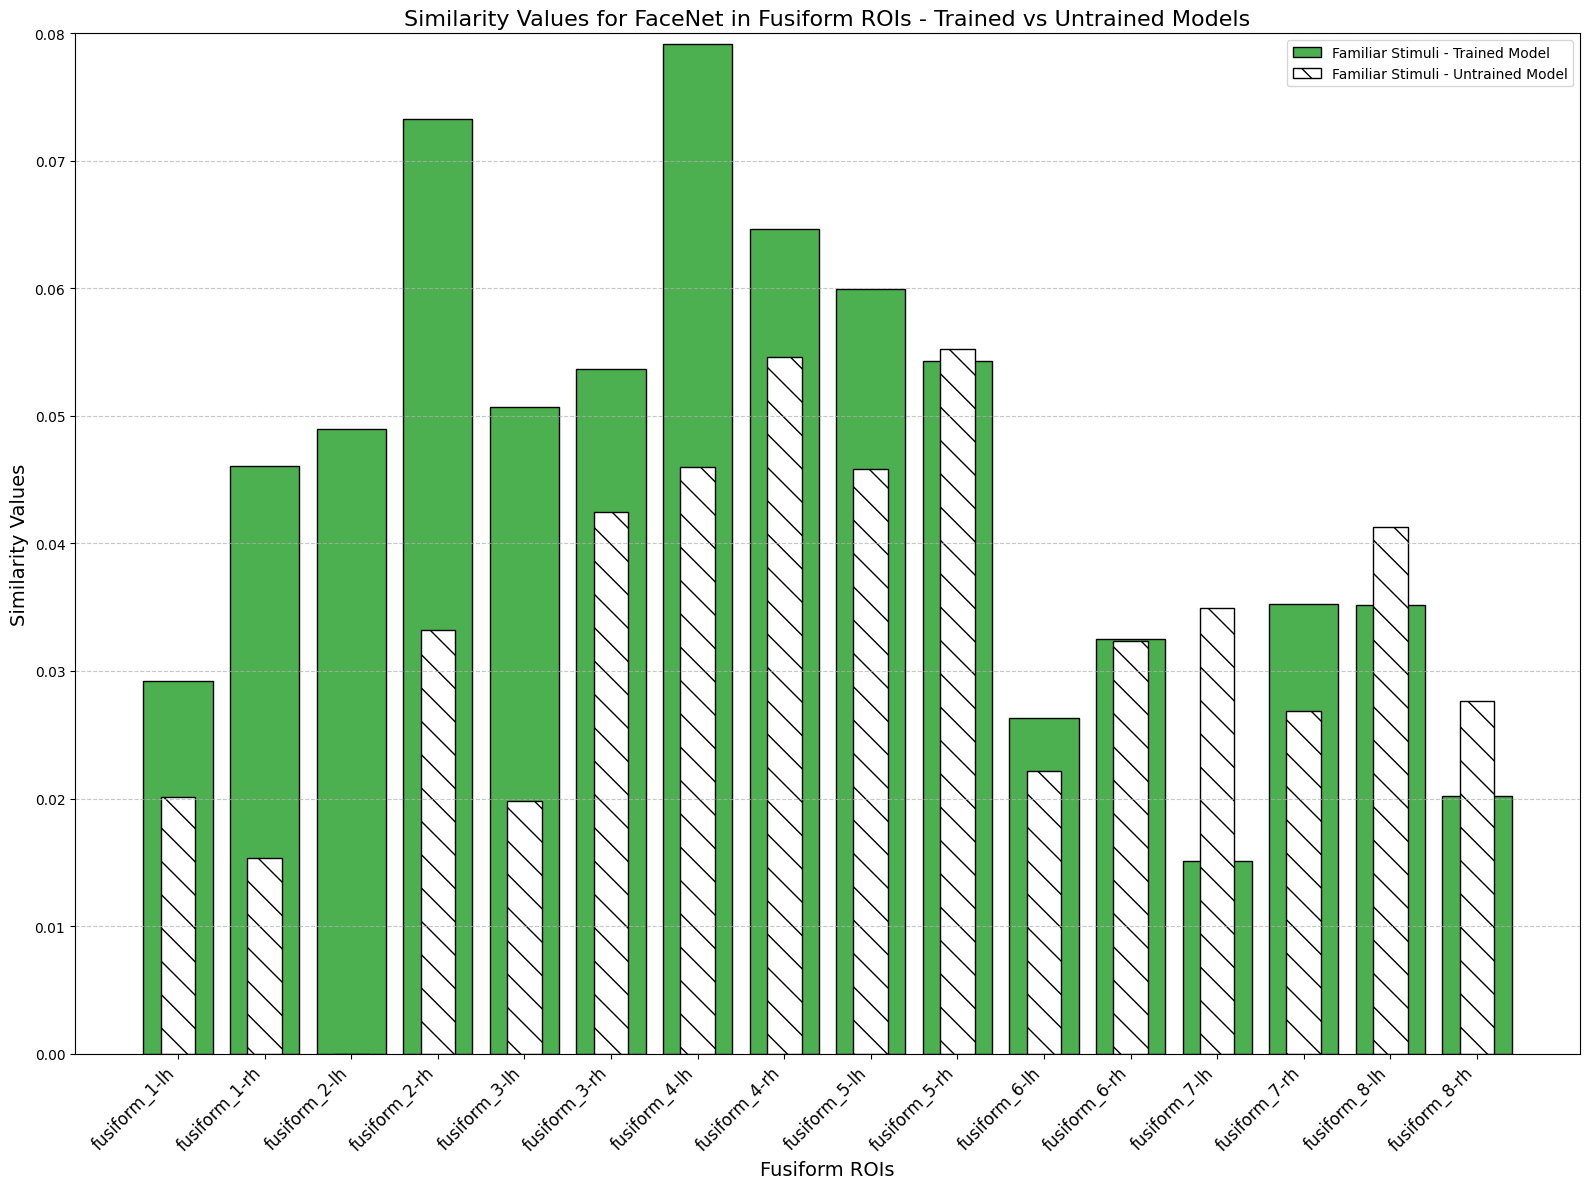

In [416]:
# Given model and analysis for unfamilar stimuli
model = "FaceNet"
analysis = "with-meg_pretrained"
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

# Plotting the bar chart for unfamiliar stimuli in light green
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', edgecolor='black', label='Familiar Stimuli - Trained Model')

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

# Plotting the bar chart for familiar stimuli in sky blue with reduced width for better visualization
ax.bar(np.arange(len(fusiform_labels)), values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=0.4, label='Familiar Stimuli - Untrained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)))
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=14)
ax.set_xlabel('Fusiform ROIs', fontsize=14)
ax.set_title(f'Similarity Values for {model} in Fusiform ROIs - Trained vs Untrained Models', fontsize=16)
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Save or display the plot
plt.tight_layout()
plt.savefig('fusiform_trained_vs_untrained.png', dpi=300, bbox_inches='tight')
plt.show()


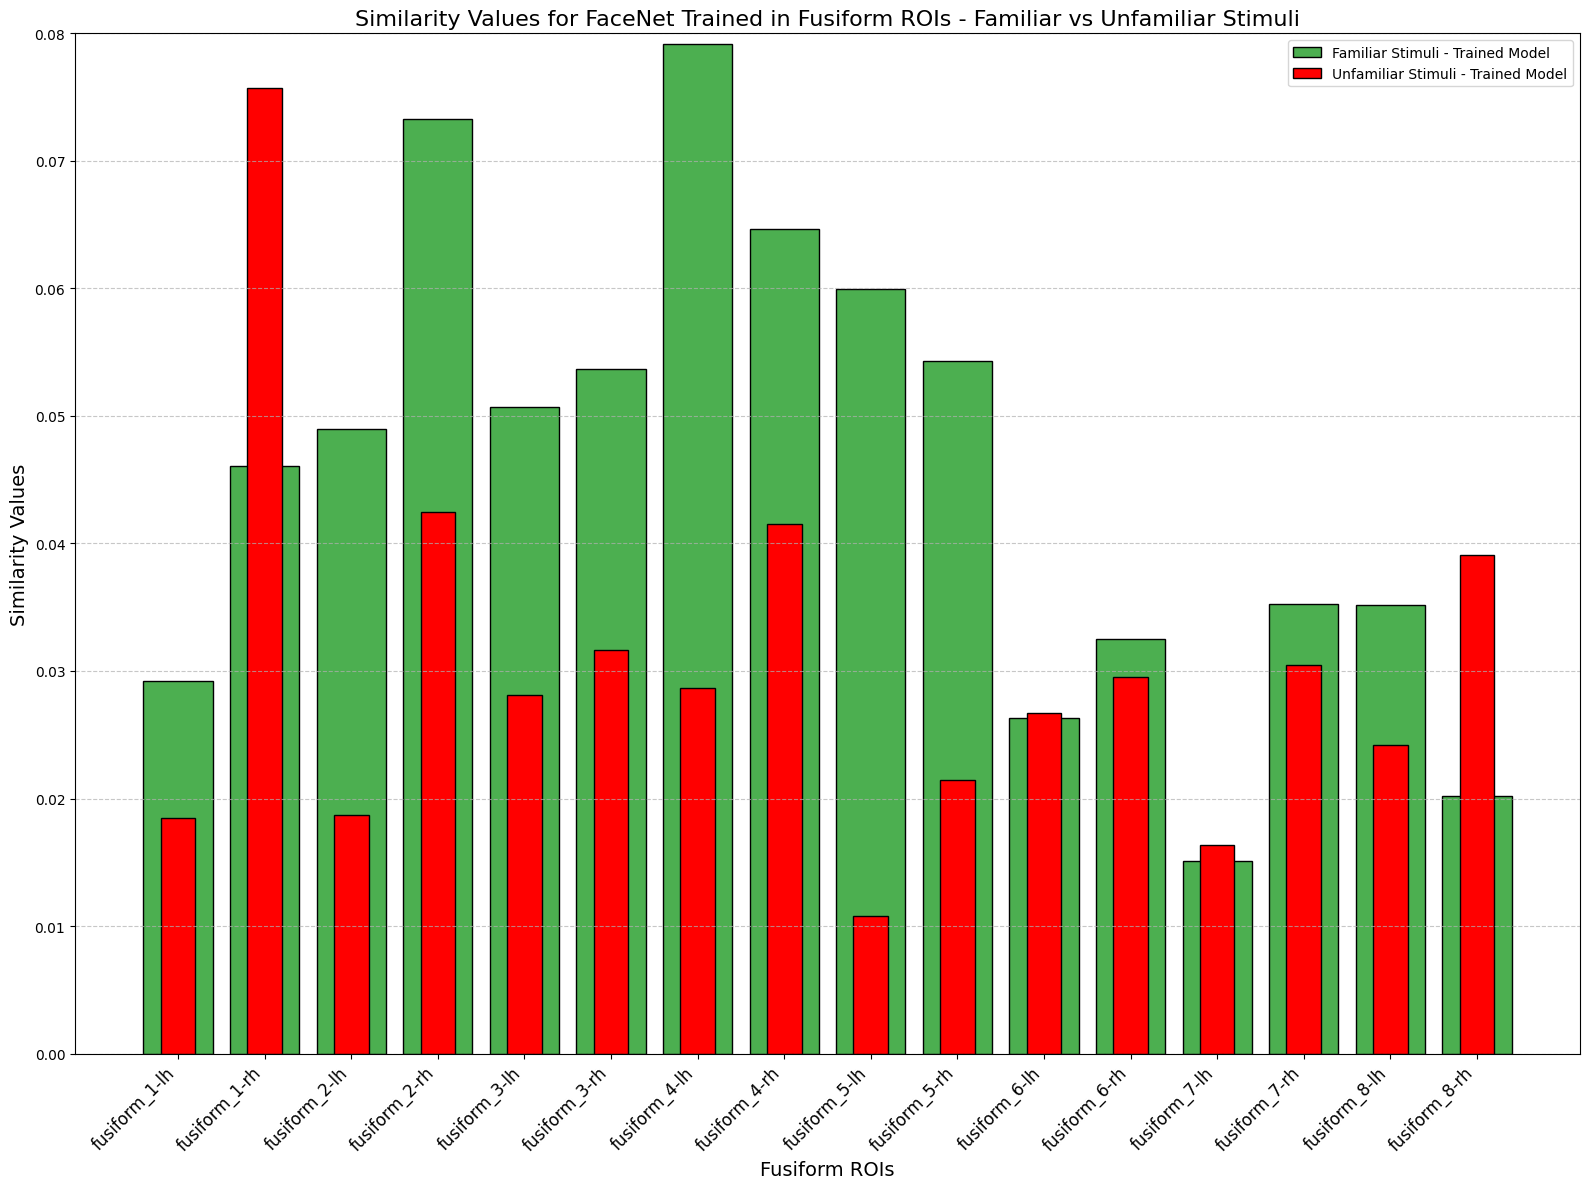

In [418]:
# Given model and analysis for familar stimuli
model = "FaceNet"
analysis = "with-meg_pretrained"
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

# Plotting the bar chart for unfamiliar stimuli in light green
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', edgecolor='black', label='Familiar Stimuli - Trained Model')

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

# Plotting the bar chart for familiar stimuli in sky blue with reduced width for better visualization
ax.bar(np.arange(len(fusiform_labels)), values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=0.4, label='Familiar Stimuli - Untrained Model')

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

# Plotting the bar chart for familiar stimuli in sky blue with reduced width for better visualization
ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', edgecolor='black', width=0.4, label='Unfamiliar Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)))
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=14)
ax.set_xlabel('Fusiform ROIs', fontsize=14)
ax.set_title(f'Similarity Values for {model} Trained in Fusiform ROIs - Familiar vs Unfamiliar Stimuli', fontsize=16)
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Save or display the plot
plt.tight_layout()
plt.show()


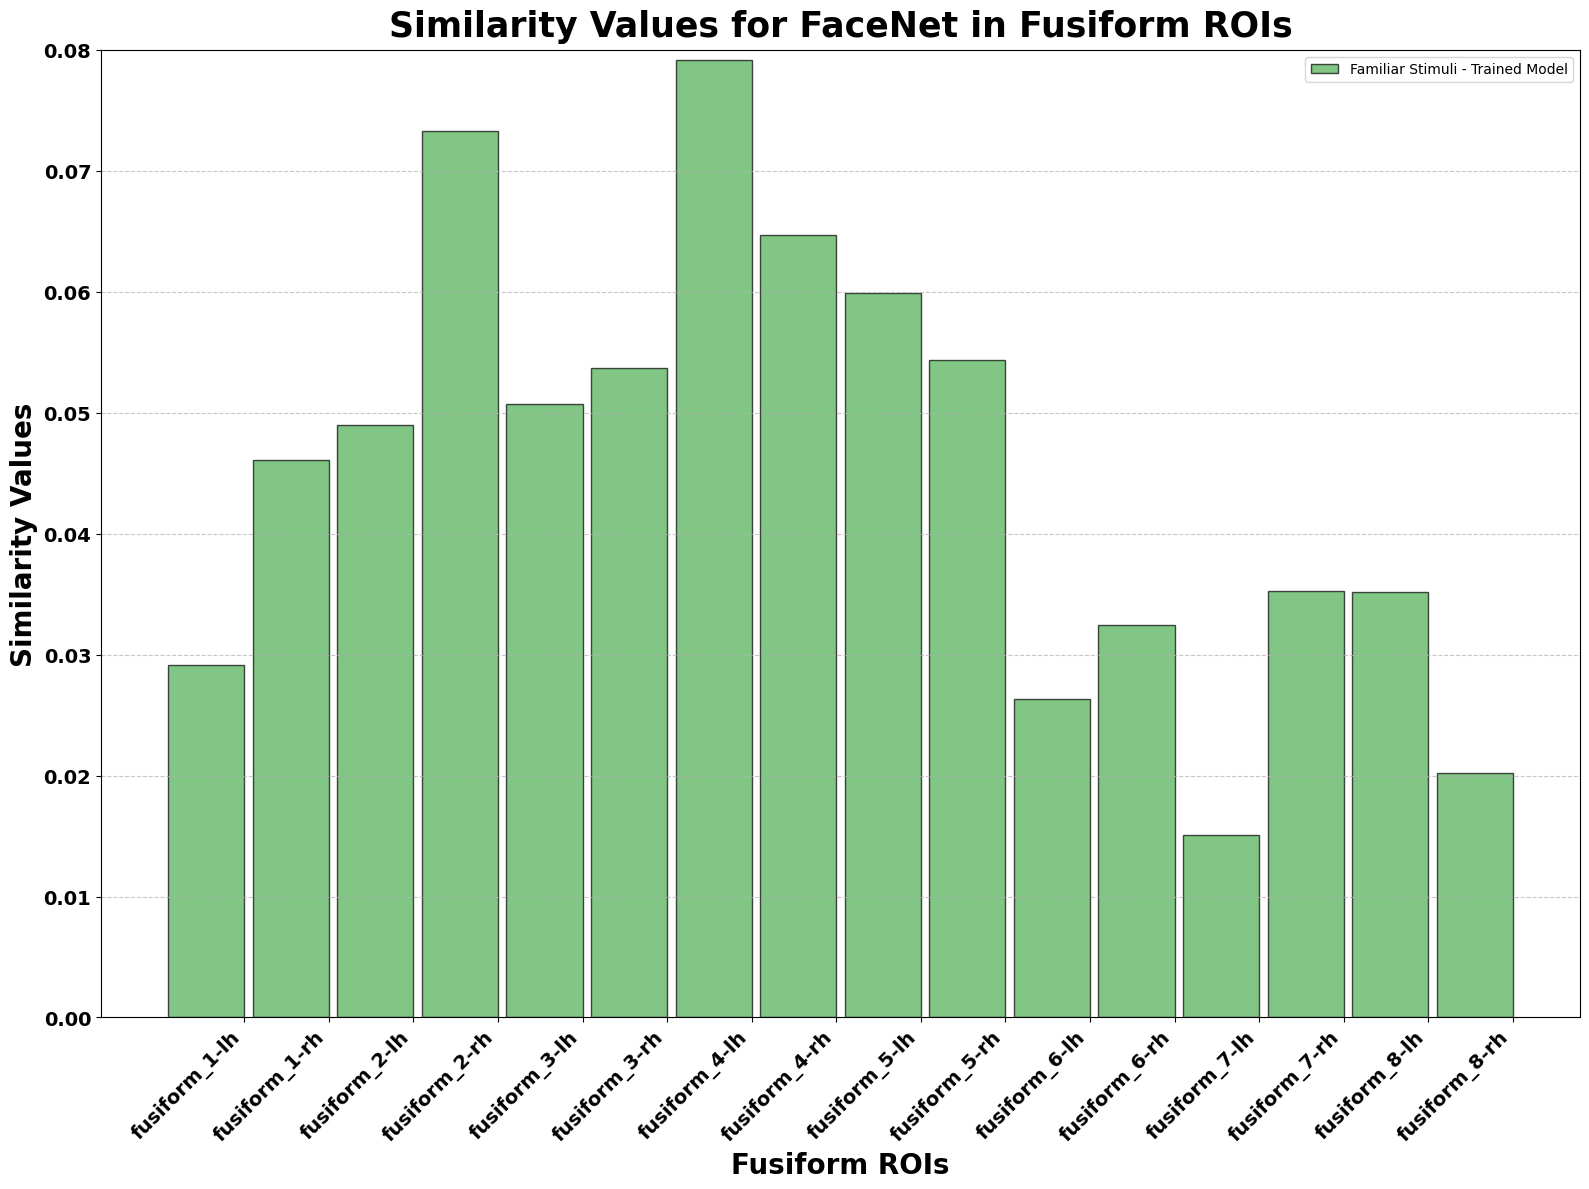

In [510]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# # Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
# ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# # Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
# ax.bar(np.arange(len(fusiform_labels)) + bar_width, values_unfamiliar[fusiform_labels], color='red', edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
# ax.bar(np.arange(len(fusiform_labels)) , values_scrambled[fusiform_labels], color='blue', edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Fusiform ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Fusiform ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')


# Save the plot
plt.savefig('fusiform1.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


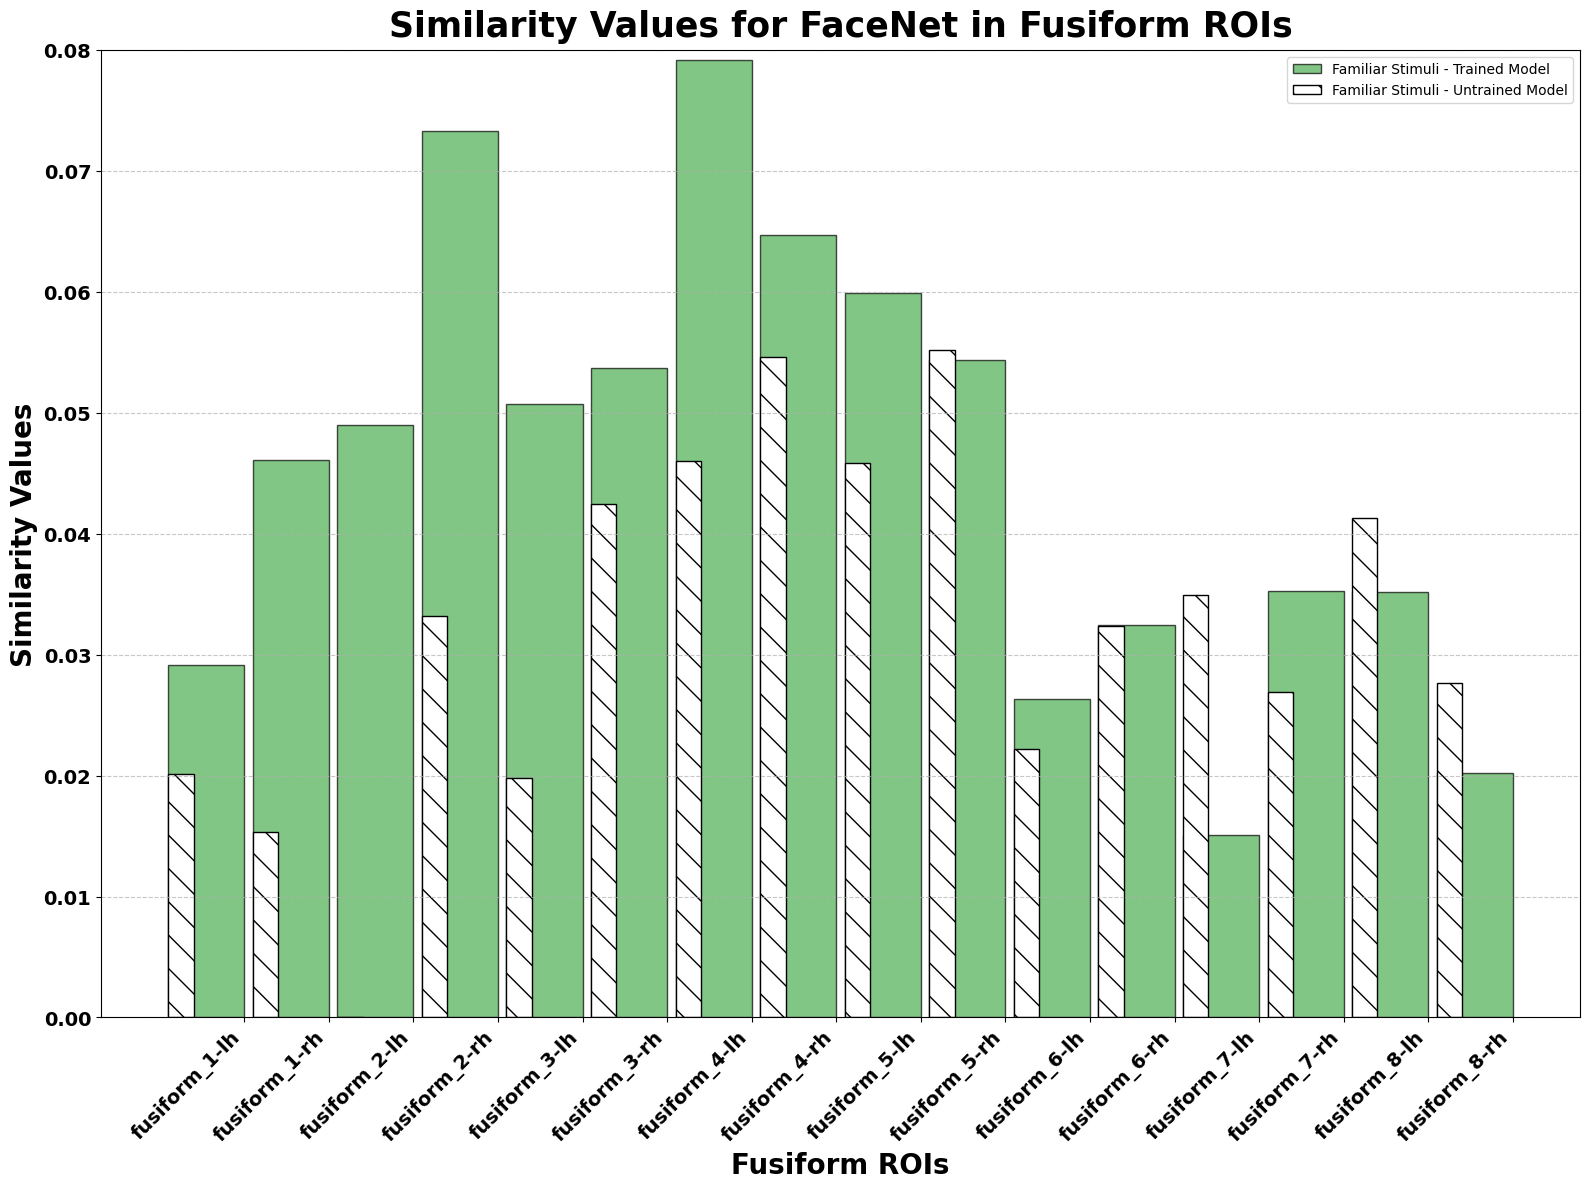

In [511]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# # Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
# ax.bar(np.arange(len(fusiform_labels)) + bar_width, values_unfamiliar[fusiform_labels], color='red', edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
# ax.bar(np.arange(len(fusiform_labels)) , values_scrambled[fusiform_labels], color='blue', edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Fusiform ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Fusiform ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.savefig('fusiform2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


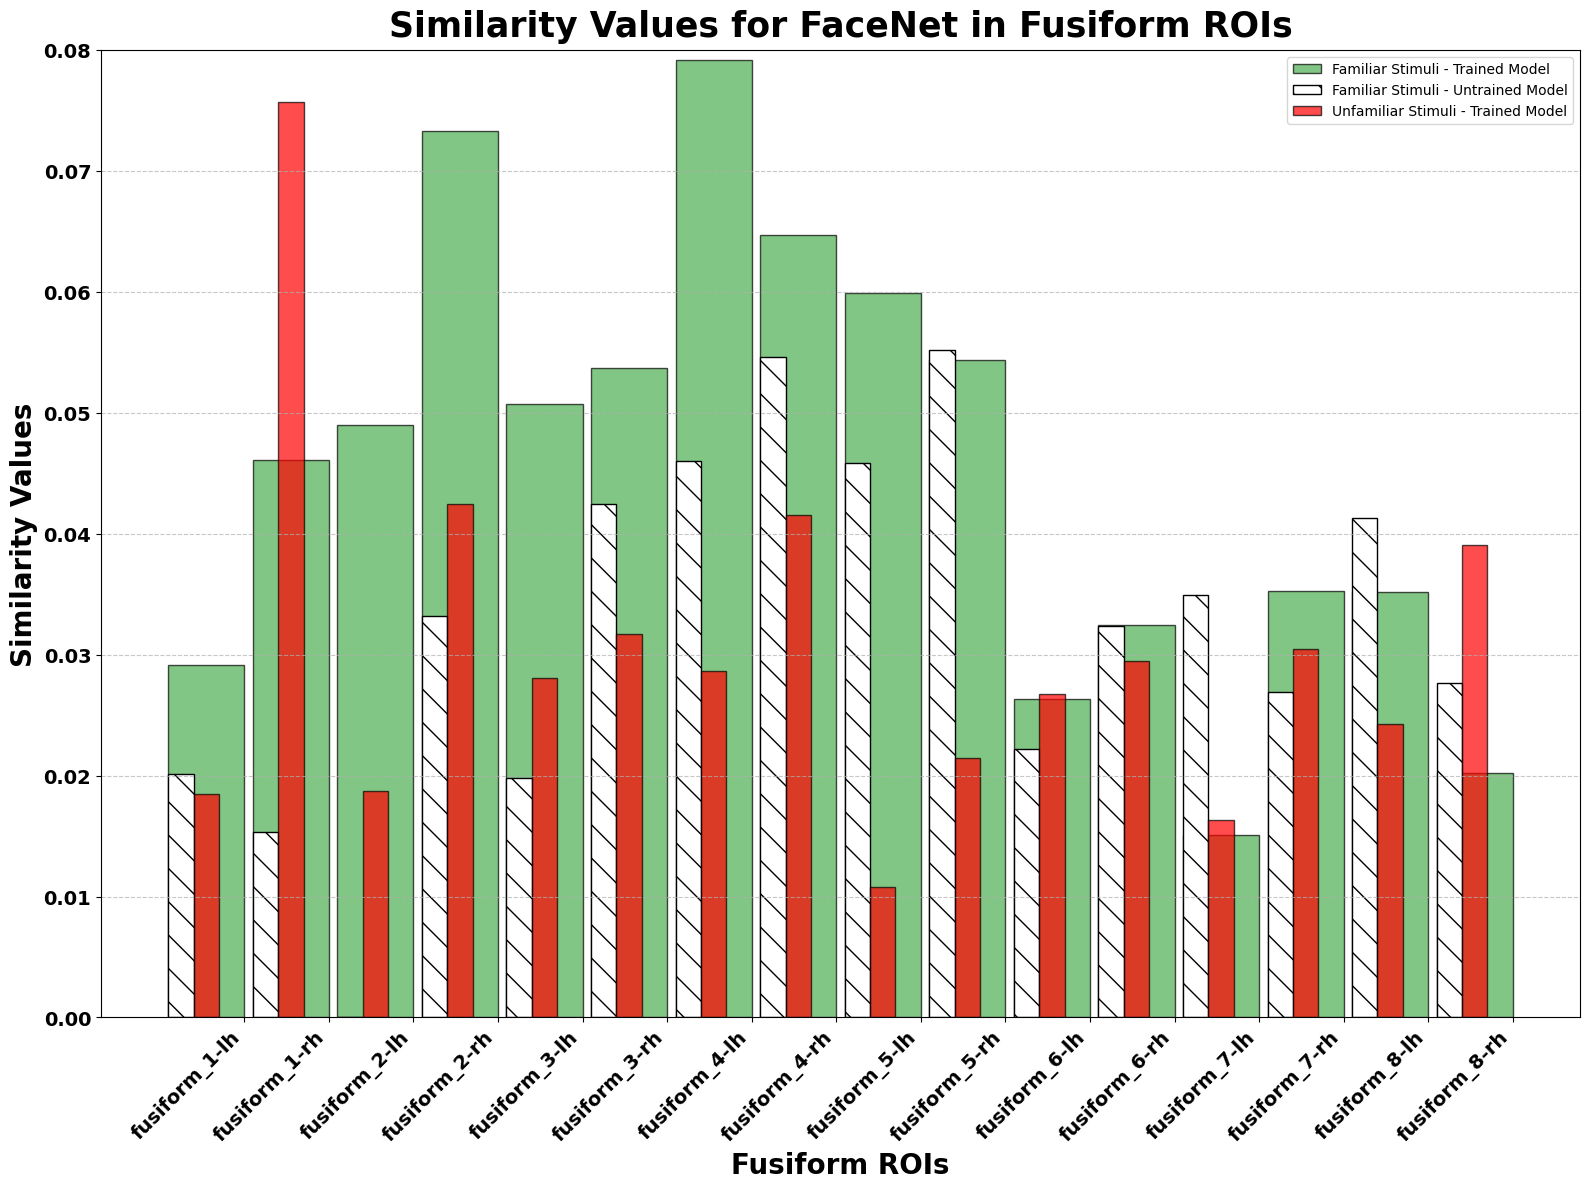

In [512]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
# ax.bar(np.arange(len(fusiform_labels)) , values_scrambled[fusiform_labels], color='blue', edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Fusiform ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Fusiform ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Save the plot
plt.savefig('fusiform3.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


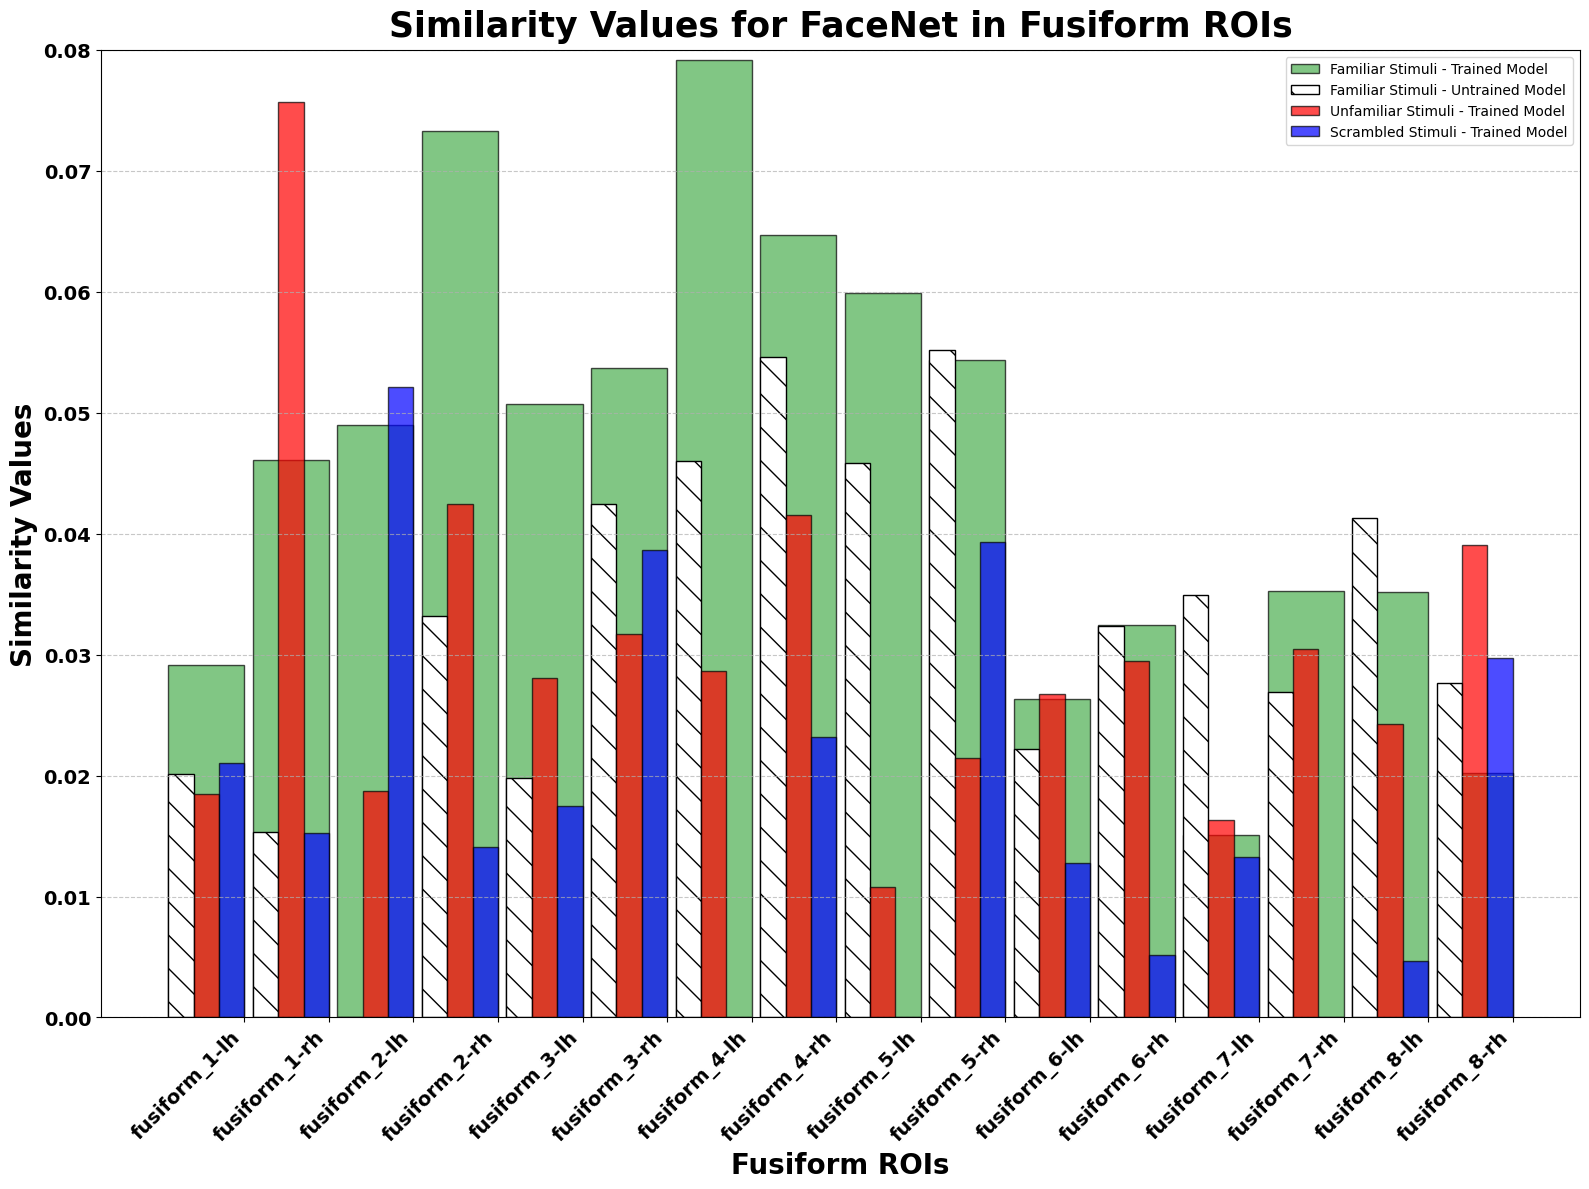

In [513]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "fusiform" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
ax.bar(np.arange(len(fusiform_labels)) + bar_width , values_scrambled[fusiform_labels], color='blue', alpha=0.7, edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Fusiform ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Fusiform ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.08)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
axs.tick_params(axis='both', which='major', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Save the plot
plt.savefig('fusiform4.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


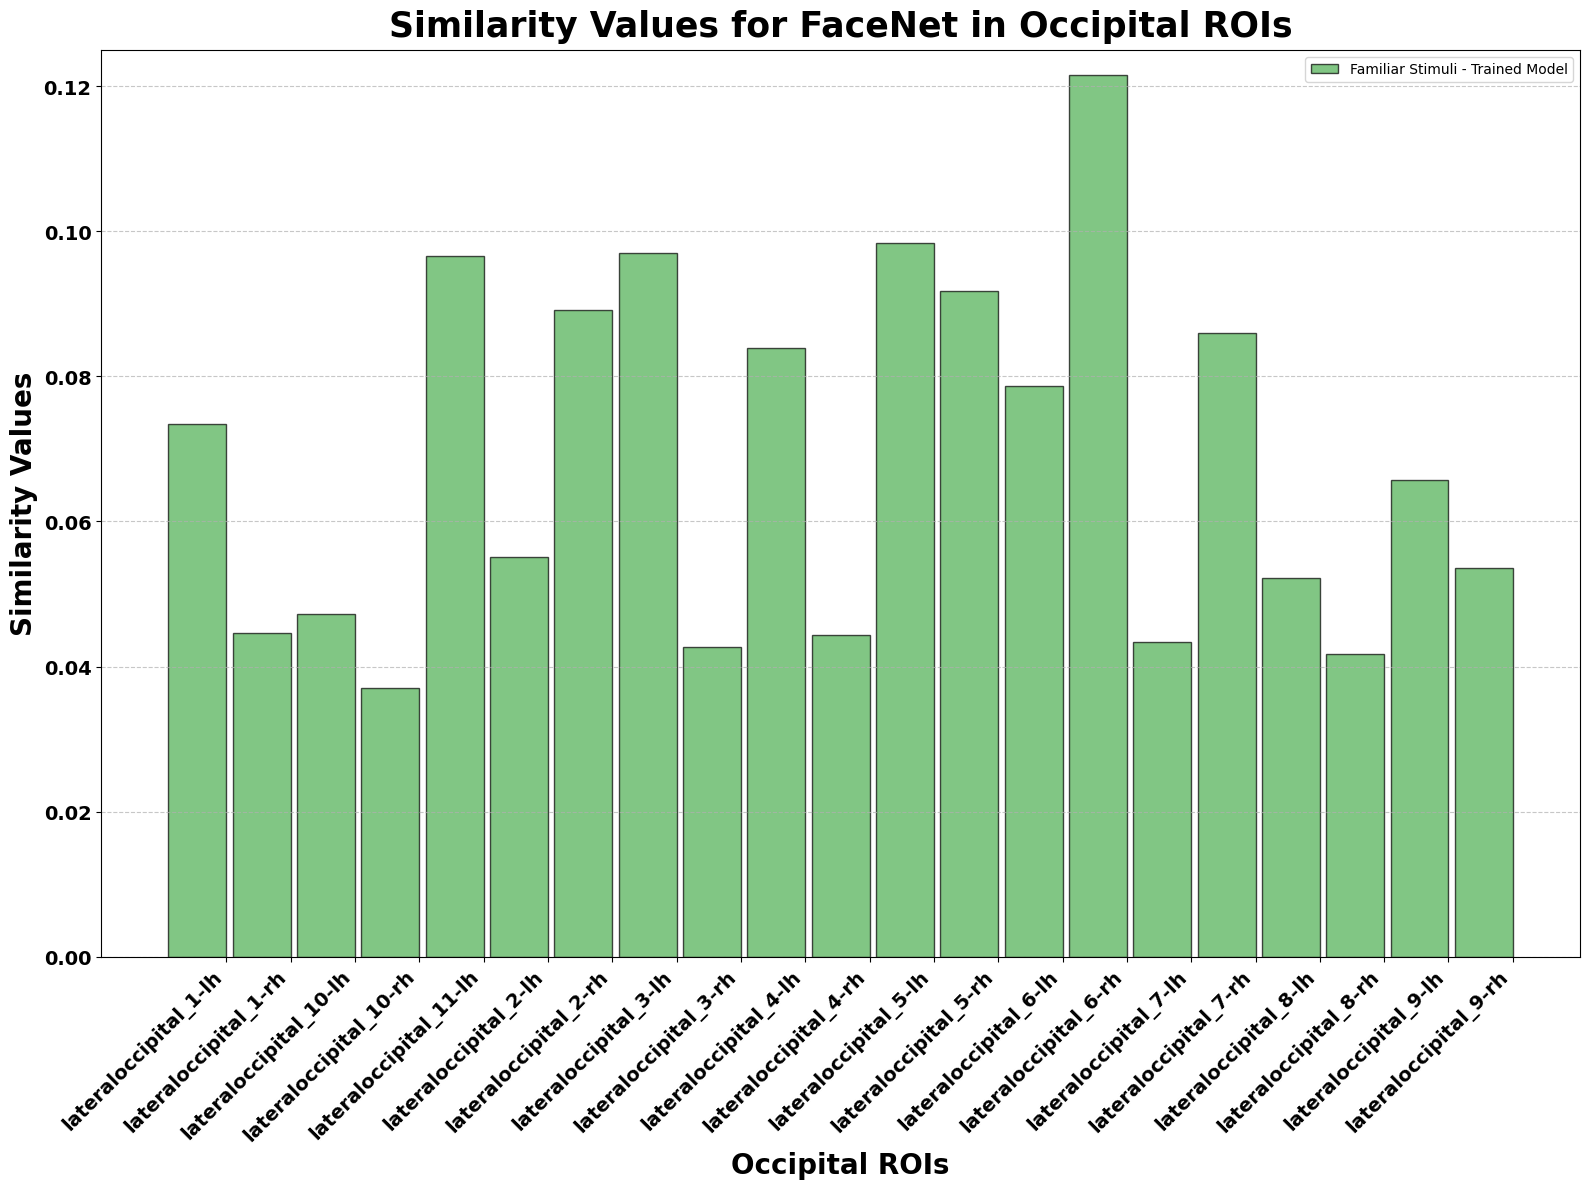

In [514]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "occipital" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# # Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
# ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# # Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
# ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
# ax.bar(np.arange(len(fusiform_labels)) + bar_width , values_scrambled[fusiform_labels], color='blue', alpha=0.7, edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Occipital ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Occipital ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.125)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

ax.legend()  # Show legend indicating the stimuli types

# Save the plot
plt.savefig('occipital1.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


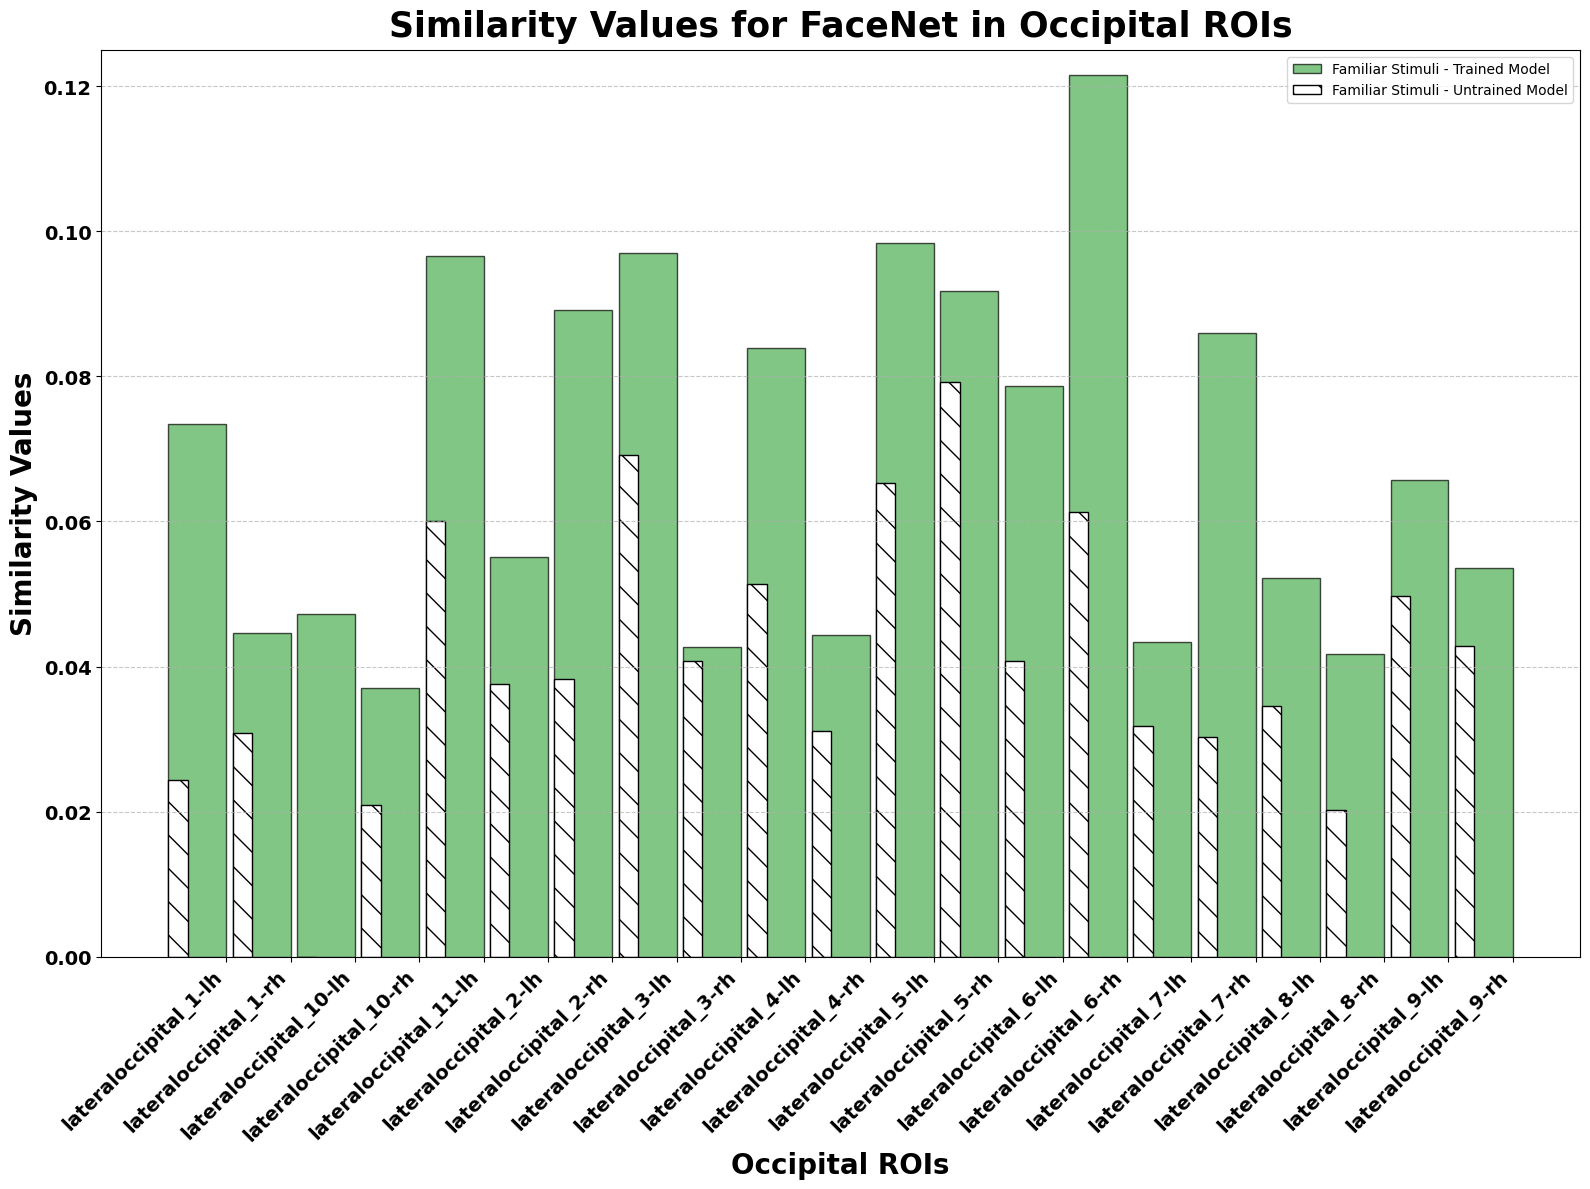

In [515]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "occipital" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# # Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
# ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
# ax.bar(np.arange(len(fusiform_labels)) + bar_width , values_scrambled[fusiform_labels], color='blue', alpha=0.7, edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Occipital ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Occipital ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.125)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

ax.legend()  # Show legend indicating the stimuli types

# Save the plot
plt.savefig('occipital2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


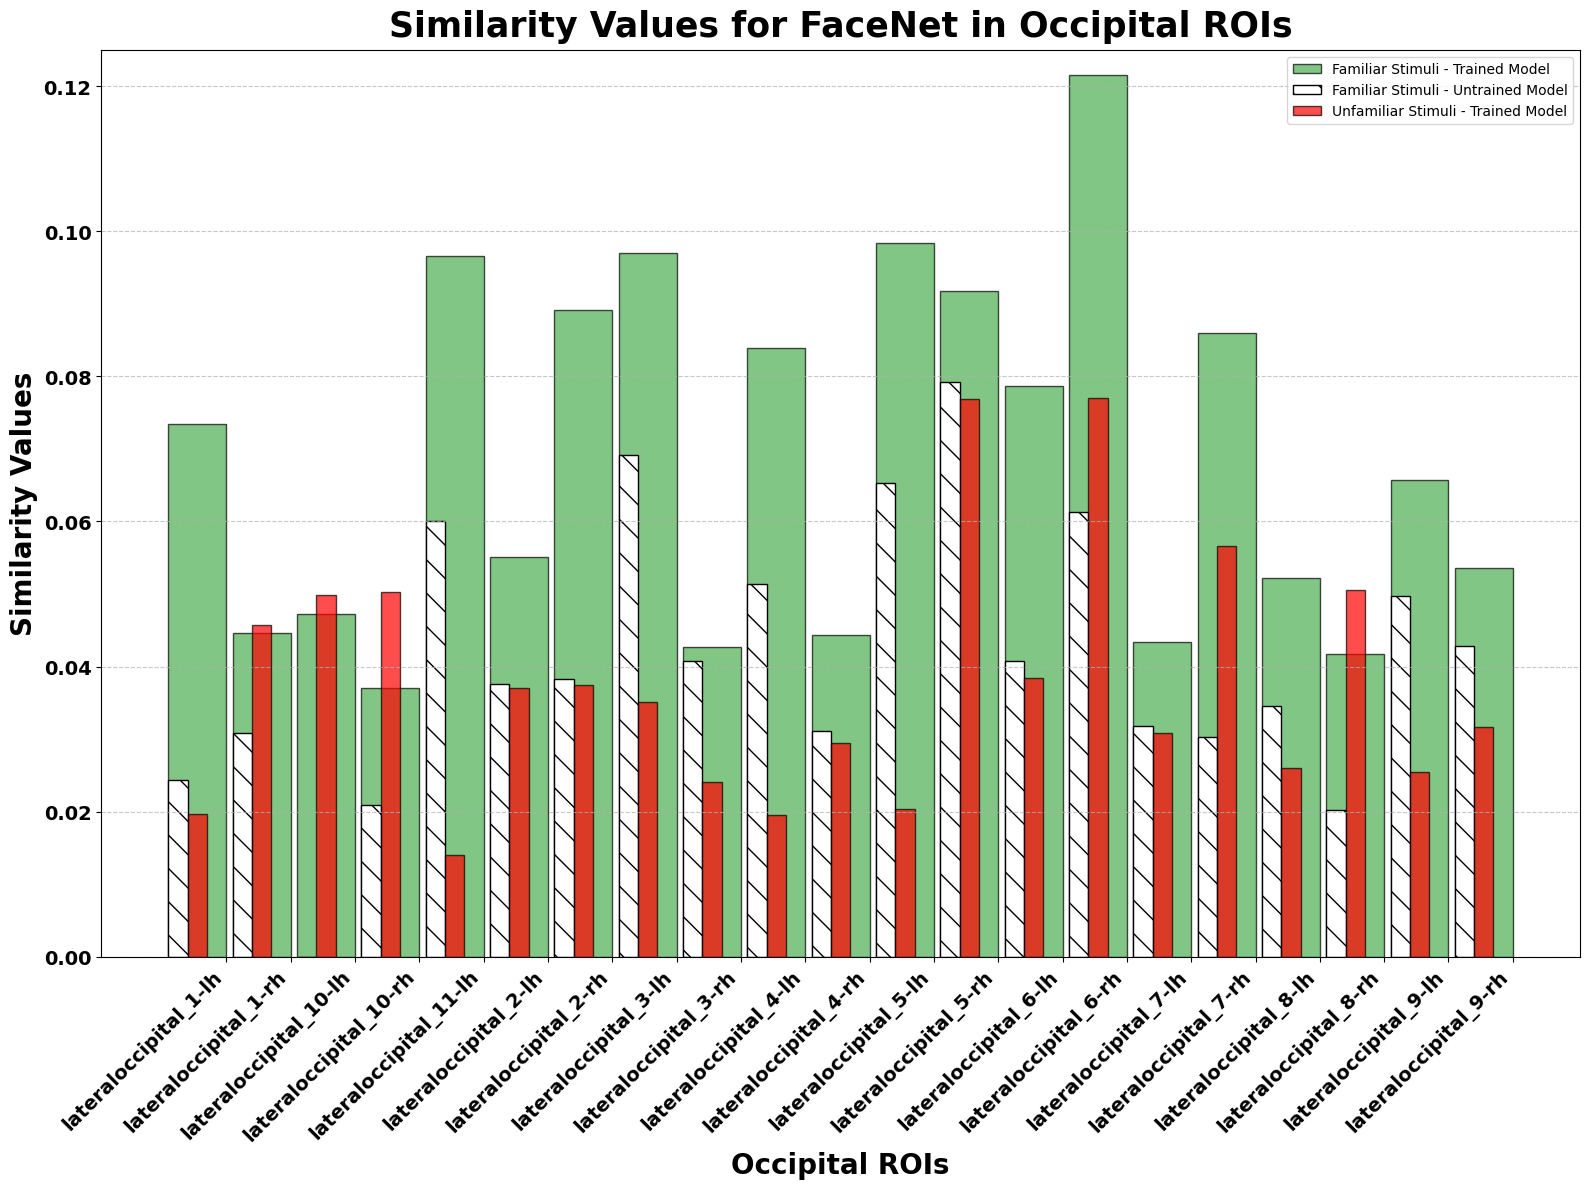

In [516]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "occipital" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
# ax.bar(np.arange(len(fusiform_labels)) + bar_width , values_scrambled[fusiform_labels], color='blue', alpha=0.7, edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Occipital ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Occipital ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.125)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

ax.legend()  # Show legend indicating the stimuli types

# Save the plot
plt.savefig('occipital3.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


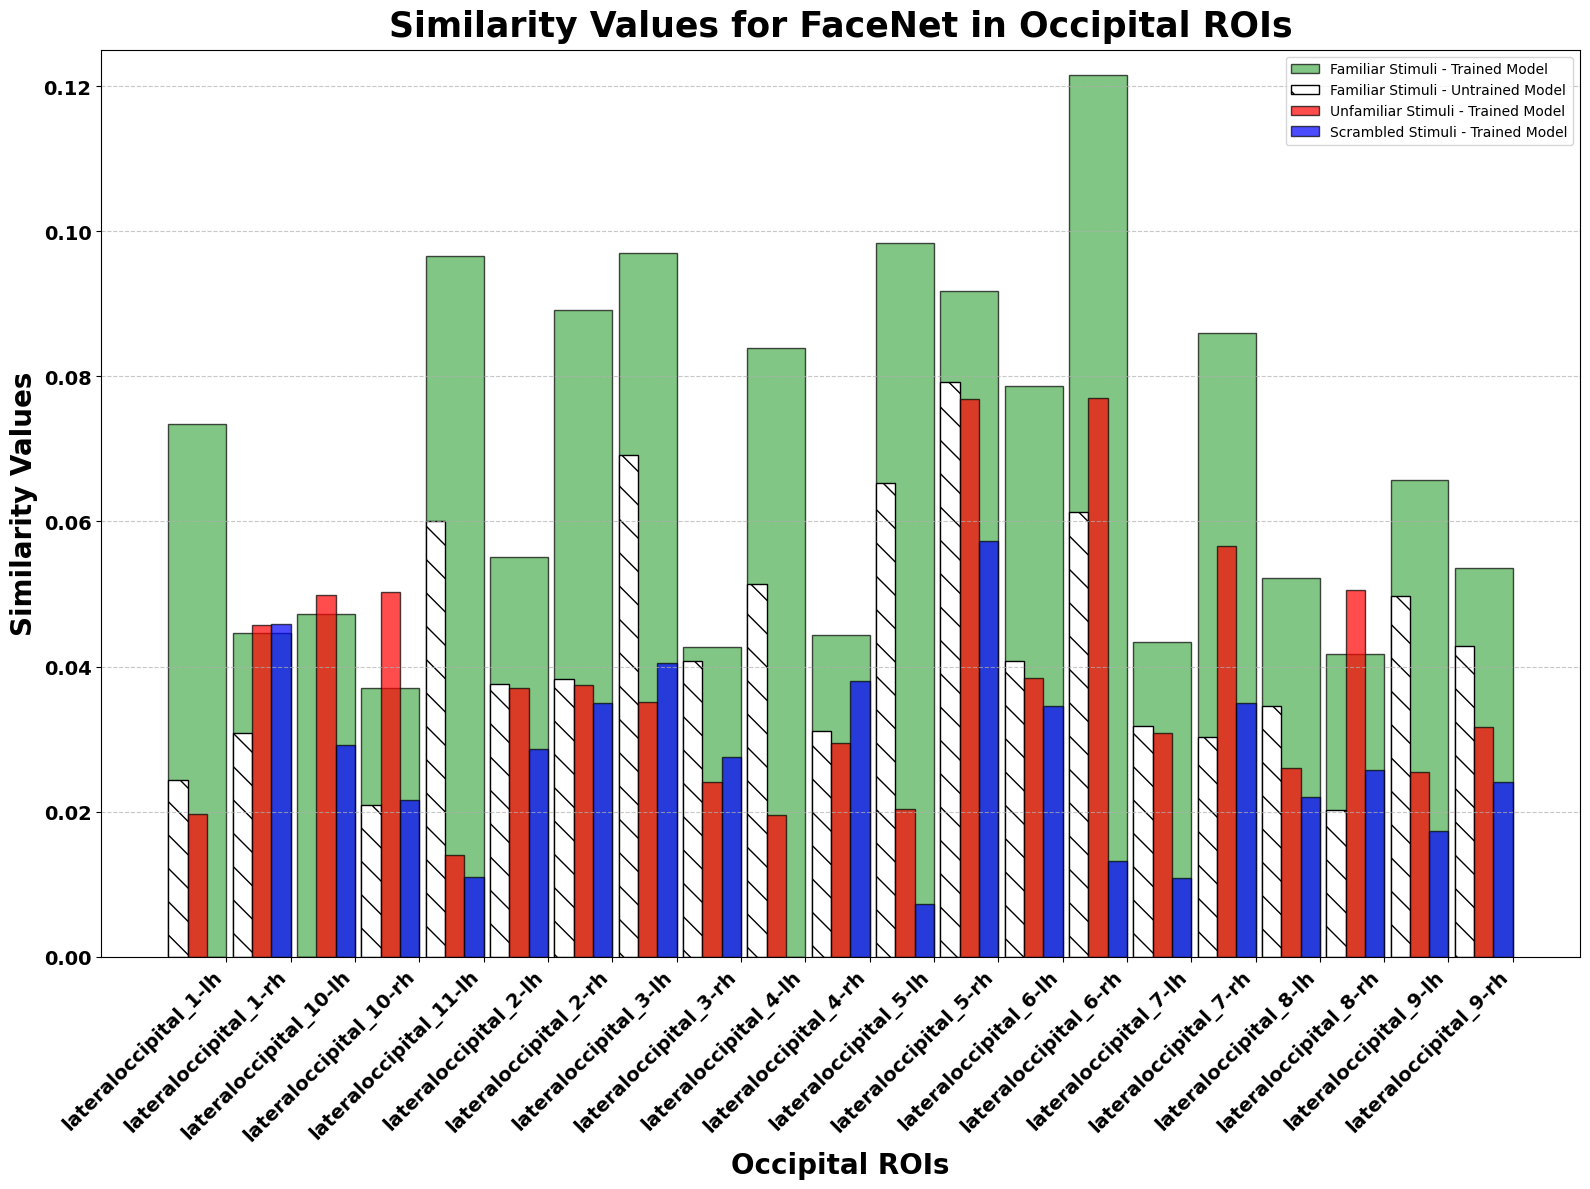

In [517]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "occipital" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
ax.bar(np.arange(len(fusiform_labels)) + bar_width , values_scrambled[fusiform_labels], color='blue', alpha=0.7, edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels
ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Occipital ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Occipital ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.125)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

ax.legend()  # Show legend indicating the stimuli types

# Save the plot
plt.savefig('occipital4.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


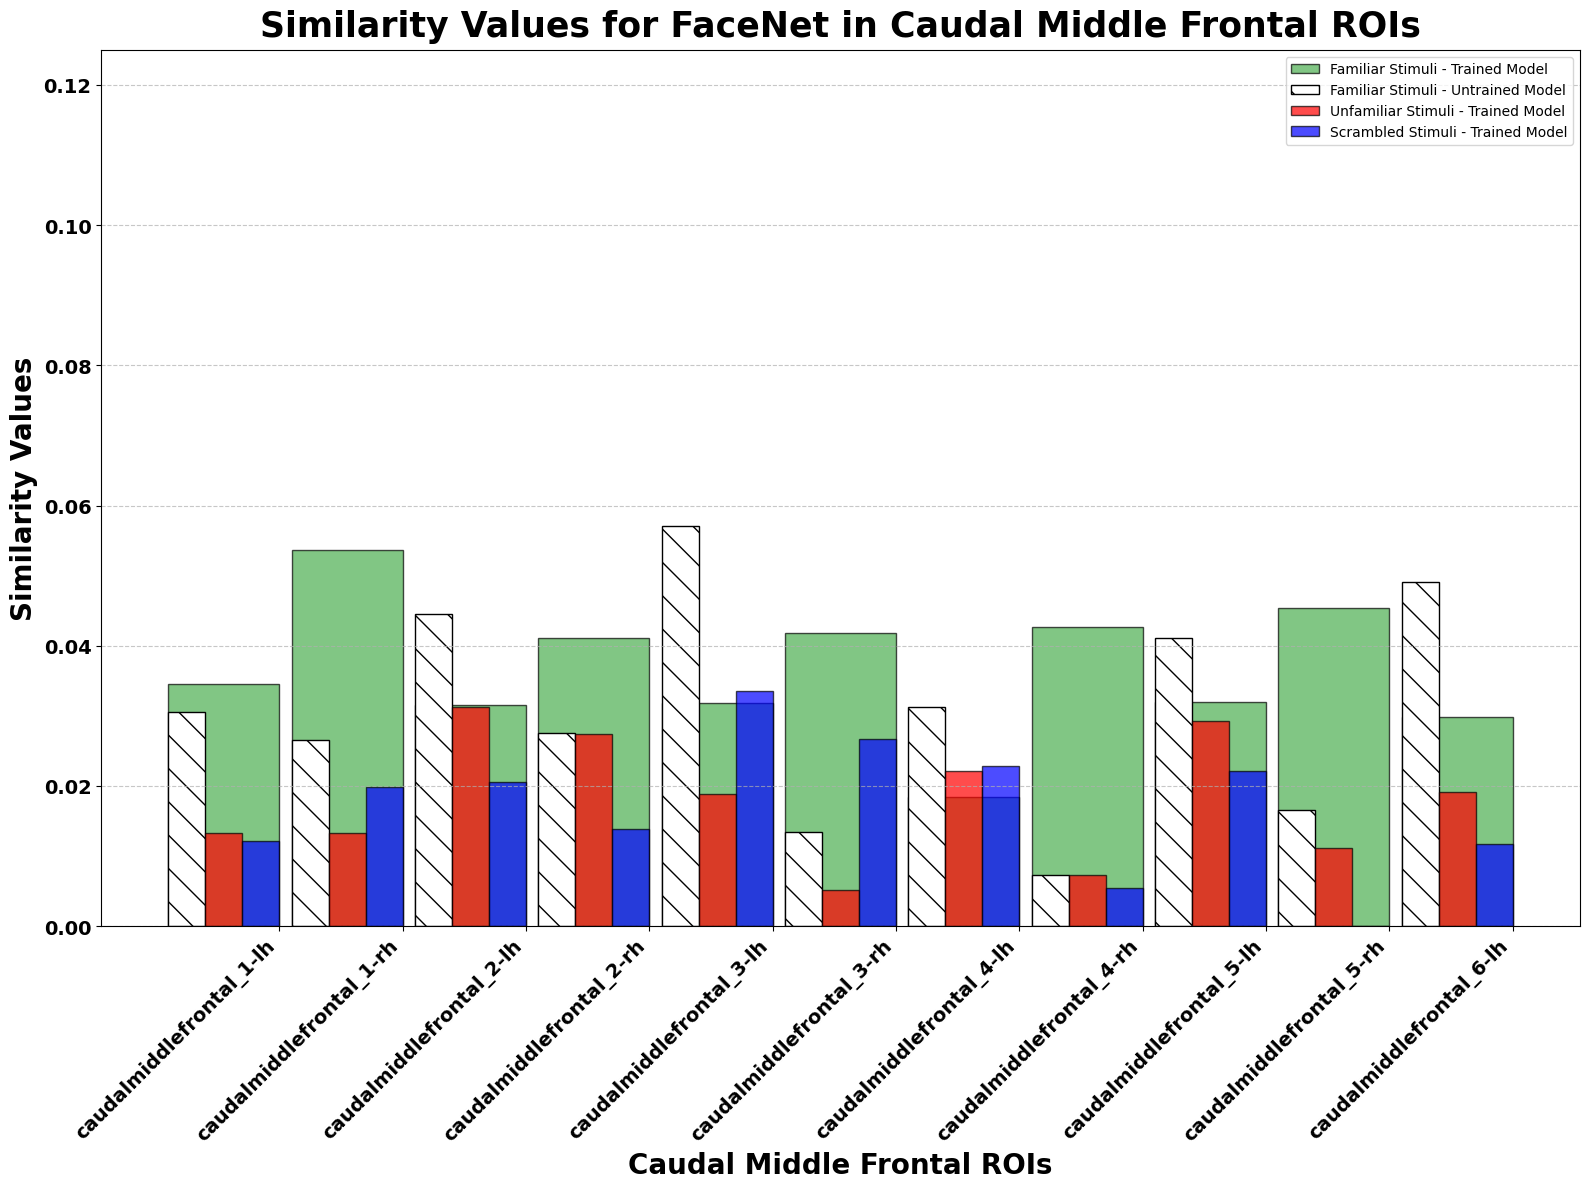

In [518]:
# Given model and analysis
model = "FaceNet"
analysis = "with-meg_pretrained"

# Load data
data_file_trained = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained.npy")
values_trained = np.max(np.load(data_file_trained)[:, 2, :, 0], axis=1)

data_file_unfamiliar = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_unfam.npy")
values_unfamiliar = np.max(np.load(data_file_unfamiliar)[:, 2, :, 0], axis=1)

data_file_untrained = os.path.join(similarity_folder, f"avg_{model}_None_rdm_untrained.npy")
values_untrained = np.max(np.load(data_file_untrained)[:, 2, :, 0], axis=1)

data_file_scrambled = os.path.join(similarity_folder, f"avg_{model}_{analysis}_rdm_trained_scrambled.npy")
values_scrambled = np.max(np.load(data_file_scrambled)[:, 2, :, 0], axis=1)

# Extract fusiform region data
fusiform_labels = [i for i, label in enumerate(rois) if "caudalmiddlefrontal" in label.name.split('_')[0]]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 12))

bar_width = 0.3  # Width of each bar

# Plotting the green bars for familiar stimuli with trained model
ax.bar(np.arange(len(fusiform_labels)), values_trained[fusiform_labels], color='#4CAF50', width = 0.9, alpha=0.7, edgecolor='black', label='Familiar Stimuli - Trained Model')

# Plotting the hashed bars for familiar stimuli with untrained model next to the red bars
ax.bar(np.arange(len(fusiform_labels)) - bar_width, values_untrained[fusiform_labels], color='white', edgecolor='black', hatch='\\', width=bar_width, label='Familiar Stimuli - Untrained Model')

# Plotting the red bars for unfamiliar stimuli with trained model next to the green bars
ax.bar(np.arange(len(fusiform_labels)), values_unfamiliar[fusiform_labels], color='red', alpha=0.7, edgecolor='black', width=bar_width, label='Unfamiliar Stimuli - Trained Model')


# # Plotting the blue bars for scrambled stimuli with trained model next to the hashed bars
ax.bar(np.arange(len(fusiform_labels)) + bar_width , values_scrambled[fusiform_labels], color='blue', alpha=0.7, edgecolor='black', width=bar_width, label='Scrambled Stimuli - Trained Model')

# Customize plot aesthetics and labels

ax.set_xticks(np.arange(len(fusiform_labels)) + 1.5 * bar_width)  # Adjust the X ticks to be in the middle of grouped bars
ax.set_xticklabels([rois[i].name for i in fusiform_labels], rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Similarity Values', fontsize=20, fontweight='bold')
ax.set_xlabel('Caudal Middle Frontal ROIs', fontsize=20, fontweight='bold')
ax.set_title(f'Similarity Values for {model} in Caudal Middle Frontal ROIs', fontsize=25, loc='center', pad=10, fontweight='bold')
ax.set_ylim(0, 0.125)
ax.legend()  # Show legend indicating the stimuli types
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Save the plot
plt.savefig('random.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()
